## DRAFT

In [8]:
nan = False
for i in range(int(len(data)/10)):
    data_selected = data.iloc[:i*10]
    for column in columns:
        if (~data_selected[column].isna()).sum()<THRESH_NAN:
            nan = True
            break
    if nan: 
        nan = False
        continue
    else:
        break

In [9]:
print('min not Nan values\t', THRESH_NAN)
print('dataset length\t\t', len(data_selected))
for column in columns:
    print(column,'\t\t', (~data_selected[column].isna()).sum())

min not Nan values	 3
dataset length		 1480
o_mus_ipr_LD 		 576
o_rat_orl_TDLo 		 19
o_mus_ipr_LDLo 		 37
o_mus_orl_TDLo 		 19
o_rat_ipr_TDLo 		 22
o_mus_ivn_LD 		 265
o_rat_ipr_LD 		 74
o_mus_orl_LD 		 536
o_mus_unr_LD 		 27
o_rat_unr_LD 		 5
o_mus_scu_LDLo 		 4
o_rat_scu_LD 		 26
o_mus_scu_LD 		 81
o_rat_ipr_LDLo 		 17
o_mus_ipr_TDLo 		 22
o_rbt_skn_LD 		 40
o_rat_orl_LD 		 168
o_rat_ivn_TDLo 		 6
o_rat_orl_LDLo 		 21
o_rbt_orl_LD 		 11
o_rbt_ivn_LD 		 3
o_rat_ivn_LD 		 23
o_mus_orl_LDLo 		 22
o_rat_skn_LD 		 15
o_mam_unr_LD 		 9
o_gpg_orl_LD 		 14
o_wmn_orl_TDLo 		 9
o_man_orl_TDLo 		 3
o_rat_scu_TDLo 		 5


# Code

In [1]:
import pandas as pd
import os
import torch
from torch.utils import data as td
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable#, Parameter

In [2]:
print(torch.__version__)

1.2.0


In [3]:
DATA_DIR = './database'
filename = 'MultiTox.csv'

## Get some data from overall dataset

In [4]:
def conformer_choice(props):
    probabilities=[props[key]['energy'] for key in props.keys()]
    conformer=np.random.choice(range(len(props)),1,probabilities)
    return np.asscalar(conformer)

In [5]:
data = pd.read_csv(os.path.join(DATA_DIR,filename))

In [6]:
columns = list(data)
columns.remove('SMILES')

In [7]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms as rdmt

In [8]:
#number of conformers created for every molecule
NUM_CONFS=100

#amount of chemical elements taking into account
AMOUNT_OF_ELEM=6

In [9]:
def create_element_dict(data,amount=9,treshold=10, add_H=False):
    elements={}
    norm=0
    for smile in data['SMILES']:
        molecule=Chem.MolFromSmiles(smile)
        molecule=Chem.AddHs(molecule)

        for i in range(molecule.GetNumAtoms()):
            atom = molecule.GetAtomWithIdx(i)
            element=atom.GetSymbol()
            norm+=1
            if element in elements.keys():
                elements[element]+=1
            else:
                elements[element]=1
    for key in elements.keys():
        elements[key]/=norm
    from collections import OrderedDict
    dd = OrderedDict(sorted(elements.items(), key=lambda x: x[1]))
    elements=list(dd.keys())[-amount:]  
    elements=dict((elem,i) for i, elem in enumerate(elements))  
    if not add_H:
        del elements['H']
    return elements

In [10]:
elements=create_element_dict(data,amount=AMOUNT_OF_ELEM,add_H=True)

In [11]:
elements

{'Cl': 0, 'S': 1, 'N': 2, 'O': 3, 'C': 4, 'H': 5}

In [12]:
import load_data_multitox as ld
from sklearn.preprocessing import StandardScaler

In [13]:
DATASET_PATH='./'

In [14]:
conf_calc = ld.reading_sql_database(DATASET_PATH)

In [15]:
scaler = StandardScaler()
data[columns]=scaler.fit_transform(data[columns])

In [16]:
indexing, label_dict = ld.indexing_label_dict(data, conf_calc)

## Dataset

In [37]:
class Gauss_dataset(td.Dataset):
    def __init__(self,conf_calc,label_dict,elements,indexing, indexes,dx=0.5,dim=70):
        self.Xs=conf_calc
        self.Ys=label_dict
        self.elements=elements
        self.indexing = indexing
        self.dx = dx
#         self.sigma=sigma
#         self.dim=dim
#         self.dx=dx
#         self.kern_dim=kern_dim
        self.indexes=indexes
        self.dim = dim

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.indexes)

    def __getitem__(self, index):
        from math import floor
        'Generates one sample of data'
        dimelem = len(self.elements)
        
        cube=torch.zeros((dimelem,self.dim,self.dim,self.dim))
        
        i=self.indexes[index]
        smiles=self.indexing[i]
        
        y= self.Ys[smiles]

        description=self.Xs[smiles][conformer_choice(self.Xs[smiles])]['coordinates']
#         X = gaussian_blur(description,self.elements,sigma=self.sigma,dimx=self.dim,dx=self.dx,kern_dim=self.kern_dim)

        for atom in description.keys():
        
            num_atom=elements[atom]

            for x0,y0,z0 in description[atom]:
                cube[num_atom, max(0,min(self.dim-1,floor(self.dim/2+x0/self.dx))), max(0,min(self.dim-1,floor(self.dim/2+y0/self.dx))), max(0,min(self.dim-1,floor(self.dim/2+z0/self.dx)))]=1
        X= cube
        return X, y
    

In [38]:
VOXEL_DIM = 70
TARGET_NUM = 29
args={'BATCH_SIZE':1}

In [39]:
class Net(nn.Module):
    def __init__(self, dim=70, dx=0.5,kern_dim=50,num_elems=6, num_targets=12, batch_size=args['BATCH_SIZE'], elements=elements):
        super(Net, self).__init__()

        self.sigma = Parameter(6*torch.ones(num_elems).float().to(device),requires_grad=True)
#         self.sigma.
        
        # initialize dimensions
        self.dim = dim
        self.num_elems = num_elems
        self.num_targets = num_targets
        self.batch_size = batch_size
        self.elements=elements
        self.dx=dx
        self.kern_dim=kern_dim

        # create layers
        self.conv1 = nn.Conv3d(num_elems, 32, kernel_size=(3, 3, 3))
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv3 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv4 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, TARGET_NUM)

        # initialize dense layer's weights
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(0.01)

        self.convolution = nn.Sequential(
            self.conv1,
            self.pool1,
            nn.ReLU(),
            self.conv2,
            self.pool2,
            nn.ReLU(),
            self.conv3,
            self.pool3,
            nn.ReLU(),
            self.conv4,
            self.pool4,
            nn.ReLU()
        )

        def weights_init(m):
            if type(m) == nn.Conv3d:
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        # initialize convolutional layers' weights
        self.convolution.apply(weights_init)
        
    def gaussian_blur (self, batch):#(molecule,elements,sigma=2,dimx=70,dx=0.5,kern_dim=50):
        from math import floor

        dimx=self.dim
        dx=self.dx
        kern_dim=self.kern_dim
        
        
        batch=batch.to(device)
        dimelem=len(elements)
#         cube=torch.zeros((dimelem,dimx,dimx,dimx))
        cube=torch.zeros(batch.shape)
        cube=cube.to(device)

        #build the kernel
#         x = torch.arange(-kern_dim/4,kern_dim/4,dx)
        
#         y = torch.arange(-kern_dim/4,kern_dim/4,dx)
#         z = torch.arange(-kern_dim/4,kern_dim/4,dx)
        x = torch.arange(-dimx/2,dimx/2)
        
        y = torch.arange(-dimx/2,dimx/2)
        z = torch.arange(-dimx/2,dimx/2)
        xx, yy, zz = torch.meshgrid((x,y,z))
        x=x.to(device)
        y=y.to(device)
        z=z.to(device)
        xx=xx.to(device)
        yy=yy.to(device)
        zz=zz.to(device)
#         print(xx)
#         kernel = torch.exp(-(xx**2 + yy**2 + zz**2)/(2*self.sigma**2))

#         for atom in molecule.keys():

#             num_atom=elements[atom]
        for idx,molecule in enumerate(batch):
            for num_atom in range(len(elements)):
                
#     #             print(xx.shape)
#     #             print(self.sigma.shape)
# #                 print(xx,yy,zz,self.sigma[num_atom])
#                 kernel = torch.exp(-(xx**2 + yy**2 + zz**2)/(2*self.sigma[num_atom]**2))
# #                 print(kernel)
                
                for x0,y0,z0 in molecule[num_atom].nonzero():
                    cube = cube + torch.exp(-((xx-x0)**2 + (yy-y0)**2 + (zz-z0)**2)/(2*self.sigma[num_atom]**2))
#                     cube = cube + torch.exp(-(xx**2 + yy**2 + zz**2)/(2*self.sigma[num_atom]**2))*torch.cos(2*np.pi/self.sigma[num_atom]*torch.sqrt(xx**2+yy**2+zz**2))
                    
#                     for i in range(cube.shape[2]):
#                         for j in range(cube.shape[3]):
#                             for k in range(cube.shape[2]):
#                                 cube[idx,num_atom,i,j,k]+=torch.exp(-((i-x0)**2 + (j-y0)**2 + (k-z0)**2)/(2*self.sigma[num_atom]**2))
# #                     print(x[0],x0,dimx)
#                     x0=x0.float()
#                     y0=y0.float()
#                     z0=z0.float()
#                     x_range=[max(floor(x[0]/dx+x0),0),min(floor(x[-1]/dx+x0+1),cube.shape[2])]
#                     y_range=[max(floor(y[0]/dx+y0),0),min(floor(y[-1]/dx+y0+1),cube.shape[3])]
#                     z_range=[max(floor(z[0]/dx+z0),0),min(floor(z[-1]/dx+z0+1),cube.shape[4])]
#                     coord_ranges=[x_range,y_range,z_range]
# #                     print(coord_ranges)
#                     for i in range(3):
#                         if coord_ranges[i][1]-coord_ranges[i][0]>50:
#                             coord_ranges[i][1]=coord_ranges[i][0]+50
#                     cube_part=cube[idx,num_atom,coord_ranges[0][0]:coord_ranges[0][1],
#                                    coord_ranges[1][0]:coord_ranges[1][1],
#                                    coord_ranges[2][0]:coord_ranges[2][1]]
# #                     print(cube.shape)
#                     kern_ranges=[[],[],[]]
#                     for i in range(3):
#                         if coord_ranges[i][0]==0:
#                             kern_ranges[i].append(kern_dim-cube_part.shape[i])
#                         else:
#                             kern_ranges[i].append(0)
#                         if coord_ranges[i][1]==cube.shape[i+1]:
#                             kern_ranges[i].append(cube_part.shape[i])
#                         else:
#                             kern_ranges[i].append(kern_dim)
                    
#                     new_kern = kernel[kern_ranges[0][0]:kern_ranges[0][1],
#                                                kern_ranges[1][0]:kern_ranges[1][1],
#                                                kern_ranges[2][0]:kern_ranges[2][1]]*1.0
#                     mask = torch.zeros_like(kernel)
#                     for i_k,i_c in zip(range(kern_ranges[0][0],kern_ranges[0][1]),range(coord_ranges[0][0],coord_ranges[0][1])):
#                         for j_k,j_c in zip(range(kern_ranges[1][0],kern_ranges[1][1]),range(coord_ranges[1][0],coord_ranges[1][1])):
#                             for k_k,k_c in zip(range(kern_ranges[2][0],kern_ranges[2][1]),range(coord_ranges[2][0],coord_ranges[2][1])):
# #                                 mask[i,j,k]=1
#                                 cube[idx,num_atom,i_c,j_c,k_c]+=kernel[i_k,j_k,k_k]
                                
# #                     new_kern=kernel[mask.byte()]
#                     f = (torch.exp(-((xx-x0)**2 + (yy-y0)**2 + (zz-z0)**2)/(2*self.sigma[num_atom]**2))).sum()
# # #                     f.backward()
#                     f = cube.sum()
#                     f.backward()
#                     print(self.sigma.grad)

#                     cube_part=cube_part+kernel[kern_ranges[0][0]:kern_ranges[0][1],
#                                                kern_ranges[1][0]:kern_ranges[1][1],
#                                                kern_ranges[2][0]:kern_ranges[2][1]]
                    

#                     cube[idx,num_atom,coord_ranges[0][0]:coord_ranges[0][1],
#                          coord_ranges[1][0]:coord_ranges[1][1],
#                          coord_ranges[2][0]:coord_ranges[2][1]]=cube_part
        
        return cube


    def forward(self, x):
        x_gauss = self.gaussian_blur(x)
#         f = x_gauss.sum()
#         f.backward()
#         print(self.sigma.grad)
#         x = x.to(device)
#         x_gauss=x_gauss.to(device)
        
        x_conv = self.convolution(x_gauss)
#         conv = nn.Conv3d(6, 32, kernel_size=(3, 3, 3)).to(device)
#         f = x_conv.sum()
#         f.backward()
#         print(self.sigma.grad)
        x_vect = x_conv.view(x.shape[0], -1)
        y1 = F.relu(self.fc1(x_vect))
        y2=self.fc2(y1)
        #         multi-label (not multi-class!) classification => sigmoid non-linearity
        return y2

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=VOXEL_DIM, num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, batch_size=args['BATCH_SIZE'])
print(model)
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Net(
  (conv1): Conv3d(6, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=29, bias=True)
  (convolution): Sequential(
    (0): Conv3d(6, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False

In [41]:
from sklearn.model_selection import train_test_split
train_indexes, test_indexes, _, _ = train_test_split(np.arange(0, len(conf_calc.keys())),
                                                         np.arange(0, len(conf_calc.keys())), test_size=0.2,
                                                         random_state=115)


In [42]:
train_set = Gauss_dataset(conf_calc, label_dict, elements, indexing,train_indexes)
train_generator = td.DataLoader(train_set, batch_size=args['BATCH_SIZE'], shuffle=True)
test_set = Gauss_dataset(conf_calc, label_dict, elements, indexing, test_indexes)
test_generator = td.DataLoader(test_set, batch_size=args['BATCH_SIZE'], shuffle=False)

In [43]:
def test(model, test_generator,epoch,device,writer=None,f_loss=None):
#    print(f_auc is not None)
    with torch.no_grad():
        model.eval()
        test_loss = 0
        losses=np.zeros(TARGET_NUM)
        num_losses=np.zeros(TARGET_NUM)
        for batch_idx, (data, target) in enumerate(test_generator):
            data = data.to(device)
            target = target.to(device)
            output = model(data)   
            i=0
            for one_target,one_output in zip(target.cpu().t(),output.cpu().t()):
                with torch.no_grad():
                    mask = (one_target == one_target)
                    output_masked = torch.masked_select(one_output, mask).type_as(one_output)
                    target_masked = torch.masked_select(one_target, mask).type_as(one_output)
                    criterion=nn.MSELoss()
                    loss = criterion(output_masked.cpu(),target_masked.cpu())
                    if loss == loss:
                        losses[i]+=loss
                        num_losses[i]+=1
#                        if f_loss is not None:
#                            f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(i)+'\t'+str(loss.cpu().numpy().item())+'\n')
                    i+=1
            mask = (target == target)
            output_masked = torch.masked_select(output, mask).type_as(output)
            target_masked = torch.masked_select(target, mask).type_as(output)
#            penalty_masked = torch.masked_select(PENALTY.to(device), mask).type_as(output)
#            class_weights=(1-penalty_masked)*(target_masked).to(device)+penalty_masked

            criterion=nn.MSELoss()
            loss = criterion(output_masked, target_masked)

            test_loss += loss
            
            
#            if f_loss is not None:
#                f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(loss.cpu().numpy().item())+'\n')
#            total += output_masked.shape[0]
        test_loss /= len(test_generator.dataset)
        test_loss *= args['BATCH_SIZE']

        print('\nTest set: Average loss: {:.4f}\n'
              .format(test_loss))
    if writer is not None:
        writer.add_scalar('Test/Loss/'+str(epoch), test_loss, epoch)
    losses/=num_losses    
    for i,loss in enumerate(losses):
        if f_loss is not None and loss == loss:
            f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(i)+'\t'+str(loss)+'\n')
    return test_loss

In [44]:
def train(model, optimizer, train_generator, epoch, device, writer = None,f_loss=None,f_loss_ch = None):
    model.train()
    train_loss=0
    losses=np.zeros(TARGET_NUM)
    num_losses=np.zeros(TARGET_NUM)
    for batch_idx, (data, target) in enumerate(train_generator):
        data = data.to(device)
        target = target.to(device)
        # set gradients to zero
        optimizer.zero_grad()
        output = model(data)
        i=0
        for one_target,one_output in zip(target.cpu().t(),output.cpu().t()):
            with torch.no_grad():
                
                mask = (one_target == one_target)
                output_masked = torch.masked_select(one_output, mask).type_as(one_output)
                target_masked = torch.masked_select(one_target, mask).type_as(one_output)
                criterion=nn.MSELoss()
                loss = criterion(output_masked.cpu(),target_masked.cpu())
                if loss == loss:
                    losses[i]+=loss
                    num_losses[i]+=1
#                        if f_loss is not None:
#                            f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(i)+'\t'+str(loss.cpu().numpy().item())+'\n')
            i+=1
        # calculate output vector
        
        # create mask to get rid of Nan's in target
        mask = (target == target)
        output_masked = torch.masked_select(output, mask).type_as(output)
        target_masked = torch.masked_select(target, mask).type_as(output)
#        penalty_masked = torch.masked_select(PENALTY.to(device), mask).type_as(output)
#        pred = output_masked.ge(0.5).type_as(output)
#        try:
#            auc=roc_auc_score(target_masked.cpu().detach(),pred.cpu().detach())
#            if f_auc is not None:
#                f_auc.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(auc)+'\n')
#        except ValueError:
#            pass
        # multi-label (not multi-class!) classification=>binary cross entropy loss
#        class_weights=(1-penalty_masked)*(target_masked).to(device)+penalty_masked
        criterion=nn.MSELoss()
        loss = criterion(output_masked, target_masked)
        
        if f_loss is not None:
            f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(loss.cpu().detach().numpy().item())+'\n')
        loss.backward()
        optimizer.step()
        train_loss+=loss.cpu().detach().numpy().item()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_generator.dataset),
                       100. * batch_idx / len(train_generator), loss.item()))
    train_loss /= len(train_generator.dataset)
    train_loss *= args['BATCH_SIZE']
    print('train loss average = ', train_loss)
    if writer is not None:
        writer.add_scalar('Train/Loss/'+str(epoch), train_loss, epoch)
    losses/=num_losses    
    for i,loss in enumerate(losses):
        if f_loss_ch is not None and loss==loss:
            f_loss_ch.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(i)+'\t'+str(loss)+'\n')

In [45]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
early_stopping = EarlyStopping(patience=25, verbose=True)
for epoch in range(1, 100000):
        try:
#            train(model, optimizer, train_generator_waves, epoch,device,f_auc=f_train_auc,f_loss=f_train_loss)
#            test(model, test_generator_waves,epoch, device,f_auc=f_test_auc,f_loss=f_test_loss)
            train(model, optimizer, train_generator, epoch, device)
            test_loss = test(model, test_generator,epoch, device)
        
        except KeyError:
            print('Key Error problem')
        early_stopping(test_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        print(model.sigma)    
        torch.save(model.state_dict(), os.path.join('./', 'gauss_draft_model'))

Train Epoch: 1 [0/6658 (0%)]	Loss: 0.204927
Train Epoch: 1 [100/6658 (2%)]	Loss: 0.641661
Train Epoch: 1 [200/6658 (3%)]	Loss: 0.640593
Train Epoch: 1 [300/6658 (5%)]	Loss: 0.016408
Train Epoch: 1 [400/6658 (6%)]	Loss: 4.382380
Train Epoch: 1 [500/6658 (8%)]	Loss: 0.000536
Train Epoch: 1 [600/6658 (9%)]	Loss: 0.885476
Train Epoch: 1 [700/6658 (11%)]	Loss: 0.009306
Train Epoch: 1 [800/6658 (12%)]	Loss: 1.685156
Train Epoch: 1 [900/6658 (14%)]	Loss: 8.491997
Train Epoch: 1 [1000/6658 (15%)]	Loss: 0.048426
Train Epoch: 1 [1100/6658 (17%)]	Loss: 0.215476
Train Epoch: 1 [1200/6658 (18%)]	Loss: 3.179224
Train Epoch: 1 [1300/6658 (20%)]	Loss: 38.691326
Train Epoch: 1 [1400/6658 (21%)]	Loss: 0.289713
Train Epoch: 1 [1500/6658 (23%)]	Loss: 0.386250
Train Epoch: 1 [1600/6658 (24%)]	Loss: 0.523959
Train Epoch: 1 [1700/6658 (26%)]	Loss: 0.037003
Train Epoch: 1 [1800/6658 (27%)]	Loss: 1.289353
Train Epoch: 1 [1900/6658 (29%)]	Loss: 1.542191
Train Epoch: 1 [2000/6658 (30%)]	Loss: 0.021326
Train Epoc

Train Epoch: 3 [2700/6658 (41%)]	Loss: 0.340682
Train Epoch: 3 [2800/6658 (42%)]	Loss: 0.636856
Train Epoch: 3 [2900/6658 (44%)]	Loss: 1.638823
Train Epoch: 3 [3000/6658 (45%)]	Loss: 0.012027
Train Epoch: 3 [3100/6658 (47%)]	Loss: 3.443660
Train Epoch: 3 [3200/6658 (48%)]	Loss: 0.197425
Train Epoch: 3 [3300/6658 (50%)]	Loss: 0.395010
Train Epoch: 3 [3400/6658 (51%)]	Loss: 0.101371
Train Epoch: 3 [3500/6658 (53%)]	Loss: 0.684132
Train Epoch: 3 [3600/6658 (54%)]	Loss: 0.230485
Train Epoch: 3 [3700/6658 (56%)]	Loss: 0.324638
Train Epoch: 3 [3800/6658 (57%)]	Loss: 1.929216
Train Epoch: 3 [3900/6658 (59%)]	Loss: 2.069705
Train Epoch: 3 [4000/6658 (60%)]	Loss: 0.303666
Train Epoch: 3 [4100/6658 (62%)]	Loss: 0.569543
Train Epoch: 3 [4200/6658 (63%)]	Loss: 0.083735
Train Epoch: 3 [4300/6658 (65%)]	Loss: 0.183292
Train Epoch: 3 [4400/6658 (66%)]	Loss: 0.280745
Train Epoch: 3 [4500/6658 (68%)]	Loss: 0.045669
Train Epoch: 3 [4600/6658 (69%)]	Loss: 0.476032
Train Epoch: 3 [4700/6658 (71%)]	Loss: 0

Train Epoch: 5 [5500/6658 (83%)]	Loss: 0.050608
Train Epoch: 5 [5600/6658 (84%)]	Loss: 0.056397
Train Epoch: 5 [5700/6658 (86%)]	Loss: 0.589307
Train Epoch: 5 [5800/6658 (87%)]	Loss: 0.137523
Train Epoch: 5 [5900/6658 (89%)]	Loss: 5.882550
Train Epoch: 5 [6000/6658 (90%)]	Loss: 3.825533
Train Epoch: 5 [6100/6658 (92%)]	Loss: 0.416294
Train Epoch: 5 [6200/6658 (93%)]	Loss: 0.135205
Train Epoch: 5 [6300/6658 (95%)]	Loss: 2.962800
Train Epoch: 5 [6400/6658 (96%)]	Loss: 1.375264
Train Epoch: 5 [6500/6658 (98%)]	Loss: 0.504901
Train Epoch: 5 [6600/6658 (99%)]	Loss: 0.363050
train loss average =  0.7690870785780153

Test set: Average loss: 0.7344

Validation loss decreased (0.741185 --> 0.734377).  Saving model ...
Parameter containing:
tensor([6.0055, 6.0004, 5.9910, 5.9915, 6.0126, 6.0111], device='cuda:0',
       requires_grad=True)
Train Epoch: 6 [0/6658 (0%)]	Loss: 3.174445
Train Epoch: 6 [100/6658 (2%)]	Loss: 0.003561
Train Epoch: 6 [200/6658 (3%)]	Loss: 3.454376
Train Epoch: 6 [300/66

Train Epoch: 8 [1100/6658 (17%)]	Loss: 0.768740
Train Epoch: 8 [1200/6658 (18%)]	Loss: 0.441208
Train Epoch: 8 [1300/6658 (20%)]	Loss: 0.106583
Train Epoch: 8 [1400/6658 (21%)]	Loss: 0.517191
Train Epoch: 8 [1500/6658 (23%)]	Loss: 0.624832
Train Epoch: 8 [1600/6658 (24%)]	Loss: 0.035671
Train Epoch: 8 [1700/6658 (26%)]	Loss: 2.923753
Train Epoch: 8 [1800/6658 (27%)]	Loss: 0.015587
Train Epoch: 8 [1900/6658 (29%)]	Loss: 0.623728
Train Epoch: 8 [2000/6658 (30%)]	Loss: 4.971010
Train Epoch: 8 [2100/6658 (32%)]	Loss: 0.629784
Train Epoch: 8 [2200/6658 (33%)]	Loss: 1.716340
Train Epoch: 8 [2300/6658 (35%)]	Loss: 0.406492
Train Epoch: 8 [2400/6658 (36%)]	Loss: 1.253078
Train Epoch: 8 [2500/6658 (38%)]	Loss: 0.876151
Train Epoch: 8 [2600/6658 (39%)]	Loss: 0.000907
Train Epoch: 8 [2700/6658 (41%)]	Loss: 0.361095
Train Epoch: 8 [2800/6658 (42%)]	Loss: 6.930704
Train Epoch: 8 [2900/6658 (44%)]	Loss: 0.128574
Train Epoch: 8 [3000/6658 (45%)]	Loss: 0.285632
Train Epoch: 8 [3100/6658 (47%)]	Loss: 0

Train Epoch: 10 [3800/6658 (57%)]	Loss: 0.278035
Train Epoch: 10 [3900/6658 (59%)]	Loss: 0.140748
Train Epoch: 10 [4000/6658 (60%)]	Loss: 0.000000
Train Epoch: 10 [4100/6658 (62%)]	Loss: 0.034320
Train Epoch: 10 [4200/6658 (63%)]	Loss: 0.101736
Train Epoch: 10 [4300/6658 (65%)]	Loss: 0.079601
Train Epoch: 10 [4400/6658 (66%)]	Loss: 1.839964
Train Epoch: 10 [4500/6658 (68%)]	Loss: 0.115404
Train Epoch: 10 [4600/6658 (69%)]	Loss: 0.077935
Train Epoch: 10 [4700/6658 (71%)]	Loss: 0.283223
Train Epoch: 10 [4800/6658 (72%)]	Loss: 0.325487
Train Epoch: 10 [4900/6658 (74%)]	Loss: 0.184435
Train Epoch: 10 [5000/6658 (75%)]	Loss: 1.678139
Train Epoch: 10 [5100/6658 (77%)]	Loss: 0.861652
Train Epoch: 10 [5200/6658 (78%)]	Loss: 0.748976
Train Epoch: 10 [5300/6658 (80%)]	Loss: 0.169916
Train Epoch: 10 [5400/6658 (81%)]	Loss: 0.001432
Train Epoch: 10 [5500/6658 (83%)]	Loss: 0.111823
Train Epoch: 10 [5600/6658 (84%)]	Loss: 0.000878
Train Epoch: 10 [5700/6658 (86%)]	Loss: 1.755130
Train Epoch: 10 [580

Train Epoch: 12 [6200/6658 (93%)]	Loss: 0.998221
Train Epoch: 12 [6300/6658 (95%)]	Loss: 0.001914
Train Epoch: 12 [6400/6658 (96%)]	Loss: 1.333871
Train Epoch: 12 [6500/6658 (98%)]	Loss: 0.351436
Train Epoch: 12 [6600/6658 (99%)]	Loss: 0.201800
train loss average =  0.7532454205643252

Test set: Average loss: 0.7263

EarlyStopping counter: 1 out of 25
Parameter containing:
tensor([6.0216, 6.0059, 5.9840, 5.9757, 6.0212, 6.0161], device='cuda:0',
       requires_grad=True)
Train Epoch: 13 [0/6658 (0%)]	Loss: 0.223785
Train Epoch: 13 [100/6658 (2%)]	Loss: 0.142767
Train Epoch: 13 [200/6658 (3%)]	Loss: 1.598811
Train Epoch: 13 [300/6658 (5%)]	Loss: 0.003750
Train Epoch: 13 [400/6658 (6%)]	Loss: 2.251429
Train Epoch: 13 [500/6658 (8%)]	Loss: 0.557668
Train Epoch: 13 [600/6658 (9%)]	Loss: 0.000001
Train Epoch: 13 [700/6658 (11%)]	Loss: 0.577411
Train Epoch: 13 [800/6658 (12%)]	Loss: 0.014960
Train Epoch: 13 [900/6658 (14%)]	Loss: 0.011061
Train Epoch: 13 [1000/6658 (15%)]	Loss: 1.325270
Tra

Train Epoch: 15 [1400/6658 (21%)]	Loss: 0.731405
Train Epoch: 15 [1500/6658 (23%)]	Loss: 1.108001
Train Epoch: 15 [1600/6658 (24%)]	Loss: 0.178873
Train Epoch: 15 [1700/6658 (26%)]	Loss: 5.015226
Train Epoch: 15 [1800/6658 (27%)]	Loss: 0.191538
Train Epoch: 15 [1900/6658 (29%)]	Loss: 0.220161
Train Epoch: 15 [2000/6658 (30%)]	Loss: 0.502070
Train Epoch: 15 [2100/6658 (32%)]	Loss: 0.020762
Train Epoch: 15 [2200/6658 (33%)]	Loss: 0.749003
Train Epoch: 15 [2300/6658 (35%)]	Loss: 0.438695
Train Epoch: 15 [2400/6658 (36%)]	Loss: 2.708879
Train Epoch: 15 [2500/6658 (38%)]	Loss: 1.109595
Train Epoch: 15 [2600/6658 (39%)]	Loss: 0.010652
Train Epoch: 15 [2700/6658 (41%)]	Loss: 0.762545
Train Epoch: 15 [2800/6658 (42%)]	Loss: 0.083514
Train Epoch: 15 [2900/6658 (44%)]	Loss: 3.985953
Train Epoch: 15 [3000/6658 (45%)]	Loss: 0.208585
Train Epoch: 15 [3100/6658 (47%)]	Loss: 0.494747
Train Epoch: 15 [3200/6658 (48%)]	Loss: 2.347873
Train Epoch: 15 [3300/6658 (50%)]	Loss: 0.006251
Train Epoch: 15 [340

Train Epoch: 17 [3800/6658 (57%)]	Loss: 0.359293
Train Epoch: 17 [3900/6658 (59%)]	Loss: 0.000000
Train Epoch: 17 [4000/6658 (60%)]	Loss: 0.108254
Train Epoch: 17 [4100/6658 (62%)]	Loss: 0.479235
Train Epoch: 17 [4200/6658 (63%)]	Loss: 5.612644
Train Epoch: 17 [4300/6658 (65%)]	Loss: 0.199019
Train Epoch: 17 [4400/6658 (66%)]	Loss: 0.192682
Train Epoch: 17 [4500/6658 (68%)]	Loss: 0.551235
Train Epoch: 17 [4600/6658 (69%)]	Loss: 0.018697
Train Epoch: 17 [4700/6658 (71%)]	Loss: 1.156775
Train Epoch: 17 [4800/6658 (72%)]	Loss: 0.118376
Train Epoch: 17 [4900/6658 (74%)]	Loss: 0.147381
Train Epoch: 17 [5000/6658 (75%)]	Loss: 0.982398
Train Epoch: 17 [5100/6658 (77%)]	Loss: 2.285244
Train Epoch: 17 [5200/6658 (78%)]	Loss: 1.292034
Train Epoch: 17 [5300/6658 (80%)]	Loss: 1.935180
Train Epoch: 17 [5400/6658 (81%)]	Loss: 0.194873
Train Epoch: 17 [5500/6658 (83%)]	Loss: 0.247473
Train Epoch: 17 [5600/6658 (84%)]	Loss: 0.311153
Train Epoch: 17 [5700/6658 (86%)]	Loss: 0.581044
Train Epoch: 17 [580

Train Epoch: 19 [6200/6658 (93%)]	Loss: 0.023169
Train Epoch: 19 [6300/6658 (95%)]	Loss: 0.349033
Train Epoch: 19 [6400/6658 (96%)]	Loss: 1.540862
Train Epoch: 19 [6500/6658 (98%)]	Loss: 0.249811
Train Epoch: 19 [6600/6658 (99%)]	Loss: 0.101056
train loss average =  0.7463612246978579

Test set: Average loss: 0.7164

EarlyStopping counter: 1 out of 25
Parameter containing:
tensor([6.0378, 6.0100, 5.9762, 5.9636, 6.0302, 6.0192], device='cuda:0',
       requires_grad=True)
Train Epoch: 20 [0/6658 (0%)]	Loss: 1.565541
Train Epoch: 20 [100/6658 (2%)]	Loss: 0.013955
Train Epoch: 20 [200/6658 (3%)]	Loss: 0.776672
Train Epoch: 20 [300/6658 (5%)]	Loss: 0.004461
Train Epoch: 20 [400/6658 (6%)]	Loss: 0.428649
Train Epoch: 20 [500/6658 (8%)]	Loss: 1.603338
Train Epoch: 20 [600/6658 (9%)]	Loss: 0.086542
Train Epoch: 20 [700/6658 (11%)]	Loss: 0.168167
Train Epoch: 20 [800/6658 (12%)]	Loss: 0.046821
Train Epoch: 20 [900/6658 (14%)]	Loss: 0.989983
Train Epoch: 20 [1000/6658 (15%)]	Loss: 0.214819
Tra

Train Epoch: 22 [1600/6658 (24%)]	Loss: 0.492549
Train Epoch: 22 [1700/6658 (26%)]	Loss: 0.017199
Train Epoch: 22 [1800/6658 (27%)]	Loss: 0.172829
Train Epoch: 22 [1900/6658 (29%)]	Loss: 0.210765
Train Epoch: 22 [2000/6658 (30%)]	Loss: 0.042206
Train Epoch: 22 [2100/6658 (32%)]	Loss: 0.304113
Train Epoch: 22 [2200/6658 (33%)]	Loss: 0.148868
Train Epoch: 22 [2300/6658 (35%)]	Loss: 0.433373
Train Epoch: 22 [2400/6658 (36%)]	Loss: 1.063595
Train Epoch: 22 [2500/6658 (38%)]	Loss: 0.145533
Train Epoch: 22 [2600/6658 (39%)]	Loss: 0.061689
Train Epoch: 22 [2700/6658 (41%)]	Loss: 0.952070
Train Epoch: 22 [2800/6658 (42%)]	Loss: 2.049512
Train Epoch: 22 [2900/6658 (44%)]	Loss: 0.450909
Train Epoch: 22 [3000/6658 (45%)]	Loss: 1.414335
Train Epoch: 22 [3100/6658 (47%)]	Loss: 0.034331
Train Epoch: 22 [3200/6658 (48%)]	Loss: 0.473362
Train Epoch: 22 [3300/6658 (50%)]	Loss: 0.508216
Train Epoch: 22 [3400/6658 (51%)]	Loss: 2.666251
Train Epoch: 22 [3500/6658 (53%)]	Loss: 0.208372
Train Epoch: 22 [360

Train Epoch: 24 [4100/6658 (62%)]	Loss: 0.003697
Train Epoch: 24 [4200/6658 (63%)]	Loss: 0.006600
Train Epoch: 24 [4300/6658 (65%)]	Loss: 0.028240
Train Epoch: 24 [4400/6658 (66%)]	Loss: 0.238136
Train Epoch: 24 [4500/6658 (68%)]	Loss: 0.309334
Train Epoch: 24 [4600/6658 (69%)]	Loss: 0.130173
Train Epoch: 24 [4700/6658 (71%)]	Loss: 0.398725
Train Epoch: 24 [4800/6658 (72%)]	Loss: 0.379284
Train Epoch: 24 [4900/6658 (74%)]	Loss: 0.250107
Train Epoch: 24 [5000/6658 (75%)]	Loss: 0.588840
Train Epoch: 24 [5100/6658 (77%)]	Loss: 0.159931
Train Epoch: 24 [5200/6658 (78%)]	Loss: 2.128728
Train Epoch: 24 [5300/6658 (80%)]	Loss: 1.951343
Train Epoch: 24 [5400/6658 (81%)]	Loss: 0.033538
Train Epoch: 24 [5500/6658 (83%)]	Loss: 0.000238
Train Epoch: 24 [5600/6658 (84%)]	Loss: 11.017915
Train Epoch: 24 [5700/6658 (86%)]	Loss: 1.402519
Train Epoch: 24 [5800/6658 (87%)]	Loss: 0.017523
Train Epoch: 24 [5900/6658 (89%)]	Loss: 0.137686
Train Epoch: 24 [6000/6658 (90%)]	Loss: 2.558346
Train Epoch: 24 [61

Train Epoch: 26 [6600/6658 (99%)]	Loss: 0.252287
train loss average =  0.7417878392637188

Test set: Average loss: 0.7237

EarlyStopping counter: 8 out of 25
Parameter containing:
tensor([6.0560, 6.0144, 5.9683, 5.9519, 6.0386, 6.0233], device='cuda:0',
       requires_grad=True)
Train Epoch: 27 [0/6658 (0%)]	Loss: 2.032781
Train Epoch: 27 [100/6658 (2%)]	Loss: 0.127428
Train Epoch: 27 [200/6658 (3%)]	Loss: 0.929205
Train Epoch: 27 [300/6658 (5%)]	Loss: 8.270803
Train Epoch: 27 [400/6658 (6%)]	Loss: 0.845954
Train Epoch: 27 [500/6658 (8%)]	Loss: 0.101241
Train Epoch: 27 [600/6658 (9%)]	Loss: 0.757393
Train Epoch: 27 [700/6658 (11%)]	Loss: 0.349748
Train Epoch: 27 [800/6658 (12%)]	Loss: 0.166572
Train Epoch: 27 [900/6658 (14%)]	Loss: 1.835791
Train Epoch: 27 [1000/6658 (15%)]	Loss: 1.416655
Train Epoch: 27 [1100/6658 (17%)]	Loss: 1.714077
Train Epoch: 27 [1200/6658 (18%)]	Loss: 0.011093
Train Epoch: 27 [1300/6658 (20%)]	Loss: 0.029923
Train Epoch: 27 [1400/6658 (21%)]	Loss: 0.010896
Tra

Train Epoch: 29 [2000/6658 (30%)]	Loss: 0.745987
Train Epoch: 29 [2100/6658 (32%)]	Loss: 0.671240
Train Epoch: 29 [2200/6658 (33%)]	Loss: 0.497305
Train Epoch: 29 [2300/6658 (35%)]	Loss: 0.160409
Train Epoch: 29 [2400/6658 (36%)]	Loss: 0.001525
Train Epoch: 29 [2500/6658 (38%)]	Loss: 0.932848
Train Epoch: 29 [2600/6658 (39%)]	Loss: 3.050464
Train Epoch: 29 [2700/6658 (41%)]	Loss: 0.000151
Train Epoch: 29 [2800/6658 (42%)]	Loss: 0.020591
Train Epoch: 29 [2900/6658 (44%)]	Loss: 0.143717
Train Epoch: 29 [3000/6658 (45%)]	Loss: 0.386783
Train Epoch: 29 [3100/6658 (47%)]	Loss: 0.609273
Train Epoch: 29 [3200/6658 (48%)]	Loss: 0.518867
Train Epoch: 29 [3300/6658 (50%)]	Loss: 0.000189
Train Epoch: 29 [3400/6658 (51%)]	Loss: 1.744581
Train Epoch: 29 [3500/6658 (53%)]	Loss: 0.000078
Train Epoch: 29 [3600/6658 (54%)]	Loss: 1.187367
Train Epoch: 29 [3700/6658 (56%)]	Loss: 8.539219
Train Epoch: 29 [3800/6658 (57%)]	Loss: 0.367954
Train Epoch: 29 [3900/6658 (59%)]	Loss: 0.594325
Train Epoch: 29 [400

Train Epoch: 31 [4500/6658 (68%)]	Loss: 19.261492
Train Epoch: 31 [4600/6658 (69%)]	Loss: 2.147101
Train Epoch: 31 [4700/6658 (71%)]	Loss: 0.031824
Train Epoch: 31 [4800/6658 (72%)]	Loss: 0.365016
Train Epoch: 31 [4900/6658 (74%)]	Loss: 0.025931
Train Epoch: 31 [5000/6658 (75%)]	Loss: 0.004657
Train Epoch: 31 [5100/6658 (77%)]	Loss: 1.698212
Train Epoch: 31 [5200/6658 (78%)]	Loss: 0.362041
Train Epoch: 31 [5300/6658 (80%)]	Loss: 3.442472
Train Epoch: 31 [5400/6658 (81%)]	Loss: 0.065446
Train Epoch: 31 [5500/6658 (83%)]	Loss: 0.001625
Train Epoch: 31 [5600/6658 (84%)]	Loss: 0.013687
Train Epoch: 31 [5700/6658 (86%)]	Loss: 14.678087
Train Epoch: 31 [5800/6658 (87%)]	Loss: 0.318054
Train Epoch: 31 [5900/6658 (89%)]	Loss: 1.387067
Train Epoch: 31 [6000/6658 (90%)]	Loss: 0.200664
Train Epoch: 31 [6100/6658 (92%)]	Loss: 0.411448
Train Epoch: 31 [6200/6658 (93%)]	Loss: 0.886149
Train Epoch: 31 [6300/6658 (95%)]	Loss: 0.139719
Train Epoch: 31 [6400/6658 (96%)]	Loss: 1.461962
Train Epoch: 31 [6

Train Epoch: 34 [100/6658 (2%)]	Loss: 0.789478
Train Epoch: 34 [200/6658 (3%)]	Loss: 0.853170
Train Epoch: 34 [300/6658 (5%)]	Loss: 0.209808
Train Epoch: 34 [400/6658 (6%)]	Loss: 2.048773
Train Epoch: 34 [500/6658 (8%)]	Loss: 0.137669
Train Epoch: 34 [600/6658 (9%)]	Loss: 0.596887
Train Epoch: 34 [700/6658 (11%)]	Loss: 1.127068
Train Epoch: 34 [800/6658 (12%)]	Loss: 0.636578
Train Epoch: 34 [900/6658 (14%)]	Loss: 0.625716
Train Epoch: 34 [1000/6658 (15%)]	Loss: 1.481952
Train Epoch: 34 [1100/6658 (17%)]	Loss: 0.007090
Train Epoch: 34 [1200/6658 (18%)]	Loss: 0.104197
Train Epoch: 34 [1300/6658 (20%)]	Loss: 3.173580
Train Epoch: 34 [1400/6658 (21%)]	Loss: 0.987609
Train Epoch: 34 [1500/6658 (23%)]	Loss: 0.403418
Train Epoch: 34 [1600/6658 (24%)]	Loss: 3.280968
Train Epoch: 34 [1700/6658 (26%)]	Loss: 0.240240
Train Epoch: 34 [1800/6658 (27%)]	Loss: 0.008604
Train Epoch: 34 [1900/6658 (29%)]	Loss: 0.545594
Train Epoch: 34 [2000/6658 (30%)]	Loss: 0.000022
Train Epoch: 34 [2100/6658 (32%)]	L

Train Epoch: 36 [2600/6658 (39%)]	Loss: 0.389922
Train Epoch: 36 [2700/6658 (41%)]	Loss: 0.830315
Train Epoch: 36 [2800/6658 (42%)]	Loss: 0.031697
Train Epoch: 36 [2900/6658 (44%)]	Loss: 0.031870
Train Epoch: 36 [3000/6658 (45%)]	Loss: 0.459288
Train Epoch: 36 [3100/6658 (47%)]	Loss: 0.542643
Train Epoch: 36 [3200/6658 (48%)]	Loss: 0.009556
Train Epoch: 36 [3300/6658 (50%)]	Loss: 2.036627
Train Epoch: 36 [3400/6658 (51%)]	Loss: 0.151905
Train Epoch: 36 [3500/6658 (53%)]	Loss: 0.155683
Train Epoch: 36 [3600/6658 (54%)]	Loss: 0.776595
Train Epoch: 36 [3700/6658 (56%)]	Loss: 0.104190
Train Epoch: 36 [3800/6658 (57%)]	Loss: 1.216470
Train Epoch: 36 [3900/6658 (59%)]	Loss: 0.285762
Train Epoch: 36 [4000/6658 (60%)]	Loss: 0.435194
Train Epoch: 36 [4100/6658 (62%)]	Loss: 0.299953
Train Epoch: 36 [4200/6658 (63%)]	Loss: 0.900454
Train Epoch: 36 [4300/6658 (65%)]	Loss: 0.828929
Train Epoch: 36 [4400/6658 (66%)]	Loss: 1.066220
Train Epoch: 36 [4500/6658 (68%)]	Loss: 2.023540
Train Epoch: 36 [460

Train Epoch: 38 [5000/6658 (75%)]	Loss: 0.117043
Train Epoch: 38 [5100/6658 (77%)]	Loss: 0.073686
Train Epoch: 38 [5200/6658 (78%)]	Loss: 0.389068
Train Epoch: 38 [5300/6658 (80%)]	Loss: 0.025411
Train Epoch: 38 [5400/6658 (81%)]	Loss: 1.717649
Train Epoch: 38 [5500/6658 (83%)]	Loss: 0.035129
Train Epoch: 38 [5600/6658 (84%)]	Loss: 0.024290
Train Epoch: 38 [5700/6658 (86%)]	Loss: 0.251846
Train Epoch: 38 [5800/6658 (87%)]	Loss: 1.009682
Train Epoch: 38 [5900/6658 (89%)]	Loss: 0.290066
Train Epoch: 38 [6000/6658 (90%)]	Loss: 0.978318
Train Epoch: 38 [6100/6658 (92%)]	Loss: 1.058949
Train Epoch: 38 [6200/6658 (93%)]	Loss: 6.012948
Train Epoch: 38 [6300/6658 (95%)]	Loss: 0.067166
Train Epoch: 38 [6400/6658 (96%)]	Loss: 0.270137
Train Epoch: 38 [6500/6658 (98%)]	Loss: 0.095701
Train Epoch: 38 [6600/6658 (99%)]	Loss: 0.112266
train loss average =  0.739877535264321

Test set: Average loss: 0.7115

EarlyStopping counter: 2 out of 25
Parameter containing:
tensor([6.0888, 6.0226, 5.9511, 5.938

Train Epoch: 41 [300/6658 (5%)]	Loss: 0.041898
Train Epoch: 41 [400/6658 (6%)]	Loss: 0.114517
Train Epoch: 41 [500/6658 (8%)]	Loss: 0.128657
Train Epoch: 41 [600/6658 (9%)]	Loss: 0.571858
Train Epoch: 41 [700/6658 (11%)]	Loss: 0.553491
Train Epoch: 41 [800/6658 (12%)]	Loss: 0.735433
Train Epoch: 41 [900/6658 (14%)]	Loss: 8.438291
Train Epoch: 41 [1000/6658 (15%)]	Loss: 0.114068
Train Epoch: 41 [1100/6658 (17%)]	Loss: 0.323798
Train Epoch: 41 [1200/6658 (18%)]	Loss: 0.099891
Train Epoch: 41 [1300/6658 (20%)]	Loss: 0.205725
Train Epoch: 41 [1400/6658 (21%)]	Loss: 0.698111
Train Epoch: 41 [1500/6658 (23%)]	Loss: 0.210914
Train Epoch: 41 [1600/6658 (24%)]	Loss: 0.789665
Train Epoch: 41 [1700/6658 (26%)]	Loss: 2.603326
Train Epoch: 41 [1800/6658 (27%)]	Loss: 0.061957
Train Epoch: 41 [1900/6658 (29%)]	Loss: 0.590016
Train Epoch: 41 [2000/6658 (30%)]	Loss: 8.634033
Train Epoch: 41 [2100/6658 (32%)]	Loss: 0.017435
Train Epoch: 41 [2200/6658 (33%)]	Loss: 0.485519
Train Epoch: 41 [2300/6658 (35%

Train Epoch: 43 [2800/6658 (42%)]	Loss: 0.257714
Train Epoch: 43 [2900/6658 (44%)]	Loss: 0.159515
Train Epoch: 43 [3000/6658 (45%)]	Loss: 0.680801
Train Epoch: 43 [3100/6658 (47%)]	Loss: 0.218160
Train Epoch: 43 [3200/6658 (48%)]	Loss: 0.168850
Train Epoch: 43 [3300/6658 (50%)]	Loss: 0.059530
Train Epoch: 43 [3400/6658 (51%)]	Loss: 0.139665
Train Epoch: 43 [3500/6658 (53%)]	Loss: 0.106321
Train Epoch: 43 [3600/6658 (54%)]	Loss: 0.000410
Train Epoch: 43 [3700/6658 (56%)]	Loss: 0.065340
Train Epoch: 43 [3800/6658 (57%)]	Loss: 0.919347
Train Epoch: 43 [3900/6658 (59%)]	Loss: 0.481519
Train Epoch: 43 [4000/6658 (60%)]	Loss: 0.000643
Train Epoch: 43 [4100/6658 (62%)]	Loss: 0.585329
Train Epoch: 43 [4200/6658 (63%)]	Loss: 0.034922
Train Epoch: 43 [4300/6658 (65%)]	Loss: 0.524143
Train Epoch: 43 [4400/6658 (66%)]	Loss: 1.463127
Train Epoch: 43 [4500/6658 (68%)]	Loss: 9.096704
Train Epoch: 43 [4600/6658 (69%)]	Loss: 2.342295
Train Epoch: 43 [4700/6658 (71%)]	Loss: 0.618803
Train Epoch: 43 [480

Train Epoch: 45 [5300/6658 (80%)]	Loss: 0.655718
Train Epoch: 45 [5400/6658 (81%)]	Loss: 0.229076
Train Epoch: 45 [5500/6658 (83%)]	Loss: 0.377466
Train Epoch: 45 [5600/6658 (84%)]	Loss: 0.053977
Train Epoch: 45 [5700/6658 (86%)]	Loss: 0.454224
Train Epoch: 45 [5800/6658 (87%)]	Loss: 0.147477
Train Epoch: 45 [5900/6658 (89%)]	Loss: 0.068288
Train Epoch: 45 [6000/6658 (90%)]	Loss: 0.757116
Train Epoch: 45 [6100/6658 (92%)]	Loss: 0.855848
Train Epoch: 45 [6200/6658 (93%)]	Loss: 0.038788
Train Epoch: 45 [6300/6658 (95%)]	Loss: 0.123919
Train Epoch: 45 [6400/6658 (96%)]	Loss: 0.152886
Train Epoch: 45 [6500/6658 (98%)]	Loss: 0.404437
Train Epoch: 45 [6600/6658 (99%)]	Loss: 0.024519
train loss average =  0.7355855033494769

Test set: Average loss: 0.7182

EarlyStopping counter: 9 out of 25
Parameter containing:
tensor([6.1045, 6.0267, 5.9425, 5.9313, 6.0626, 6.0319], device='cuda:0',
       requires_grad=True)
Train Epoch: 46 [0/6658 (0%)]	Loss: 1.099632
Train Epoch: 46 [100/6658 (2%)]	Loss:

Train Epoch: 48 [600/6658 (9%)]	Loss: 0.084527
Train Epoch: 48 [700/6658 (11%)]	Loss: 0.005114
Train Epoch: 48 [800/6658 (12%)]	Loss: 0.011055
Train Epoch: 48 [900/6658 (14%)]	Loss: 0.493490
Train Epoch: 48 [1000/6658 (15%)]	Loss: 0.202840
Train Epoch: 48 [1100/6658 (17%)]	Loss: 1.127893
Train Epoch: 48 [1200/6658 (18%)]	Loss: 0.264243
Train Epoch: 48 [1300/6658 (20%)]	Loss: 0.061239
Train Epoch: 48 [1400/6658 (21%)]	Loss: 0.171583
Train Epoch: 48 [1500/6658 (23%)]	Loss: 0.105355
Train Epoch: 48 [1600/6658 (24%)]	Loss: 0.171686
Train Epoch: 48 [1700/6658 (26%)]	Loss: 0.237960
Train Epoch: 48 [1800/6658 (27%)]	Loss: 0.161240
Train Epoch: 48 [1900/6658 (29%)]	Loss: 1.000093
Train Epoch: 48 [2000/6658 (30%)]	Loss: 2.434022
Train Epoch: 48 [2100/6658 (32%)]	Loss: 0.041438
Train Epoch: 48 [2200/6658 (33%)]	Loss: 0.380574
Train Epoch: 48 [2300/6658 (35%)]	Loss: 1.509461
Train Epoch: 48 [2400/6658 (36%)]	Loss: 3.083824
Train Epoch: 48 [2500/6658 (38%)]	Loss: 3.513683
Train Epoch: 48 [2600/665

Train Epoch: 50 [3100/6658 (47%)]	Loss: 0.114026
Train Epoch: 50 [3200/6658 (48%)]	Loss: 1.288183
Train Epoch: 50 [3300/6658 (50%)]	Loss: 0.430593
Train Epoch: 50 [3400/6658 (51%)]	Loss: 0.099666
Train Epoch: 50 [3500/6658 (53%)]	Loss: 0.832640
Train Epoch: 50 [3600/6658 (54%)]	Loss: 0.268336
Train Epoch: 50 [3700/6658 (56%)]	Loss: 0.082083
Train Epoch: 50 [3800/6658 (57%)]	Loss: 1.015821
Train Epoch: 50 [3900/6658 (59%)]	Loss: 0.047544
Train Epoch: 50 [4000/6658 (60%)]	Loss: 0.467024
Train Epoch: 50 [4100/6658 (62%)]	Loss: 0.311729
Train Epoch: 50 [4200/6658 (63%)]	Loss: 0.316507
Train Epoch: 50 [4300/6658 (65%)]	Loss: 0.354737
Train Epoch: 50 [4400/6658 (66%)]	Loss: 0.491745
Train Epoch: 50 [4500/6658 (68%)]	Loss: 1.925765
Train Epoch: 50 [4600/6658 (69%)]	Loss: 0.141989
Train Epoch: 50 [4700/6658 (71%)]	Loss: 0.235082
Train Epoch: 50 [4800/6658 (72%)]	Loss: 0.059366
Train Epoch: 50 [4900/6658 (74%)]	Loss: 1.137087
Train Epoch: 50 [5000/6658 (75%)]	Loss: 0.048129
Train Epoch: 50 [510

Train Epoch: 52 [5500/6658 (83%)]	Loss: 0.449463
Train Epoch: 52 [5600/6658 (84%)]	Loss: 1.405257
Train Epoch: 52 [5700/6658 (86%)]	Loss: 0.090782
Train Epoch: 52 [5800/6658 (87%)]	Loss: 0.032388
Train Epoch: 52 [5900/6658 (89%)]	Loss: 0.115788
Train Epoch: 52 [6000/6658 (90%)]	Loss: 0.004795
Train Epoch: 52 [6100/6658 (92%)]	Loss: 0.136583
Train Epoch: 52 [6200/6658 (93%)]	Loss: 0.558378
Train Epoch: 52 [6300/6658 (95%)]	Loss: 1.449524
Train Epoch: 52 [6400/6658 (96%)]	Loss: 0.050688
Train Epoch: 52 [6500/6658 (98%)]	Loss: 0.532528
Train Epoch: 52 [6600/6658 (99%)]	Loss: 0.002578
train loss average =  0.7313366239197596

Test set: Average loss: 0.7085

EarlyStopping counter: 1 out of 25
Parameter containing:
tensor([6.1197, 6.0322, 5.9342, 5.9241, 6.0724, 6.0345], device='cuda:0',
       requires_grad=True)
Train Epoch: 53 [0/6658 (0%)]	Loss: 0.235087
Train Epoch: 53 [100/6658 (2%)]	Loss: 0.284843
Train Epoch: 53 [200/6658 (3%)]	Loss: 0.183490
Train Epoch: 53 [300/6658 (5%)]	Loss: 0.0

Train Epoch: 55 [800/6658 (12%)]	Loss: 0.000079
Train Epoch: 55 [900/6658 (14%)]	Loss: 0.014517
Train Epoch: 55 [1000/6658 (15%)]	Loss: 0.002806
Train Epoch: 55 [1100/6658 (17%)]	Loss: 1.563144
Train Epoch: 55 [1200/6658 (18%)]	Loss: 1.364799
Train Epoch: 55 [1300/6658 (20%)]	Loss: 0.695704
Train Epoch: 55 [1400/6658 (21%)]	Loss: 0.035165
Train Epoch: 55 [1500/6658 (23%)]	Loss: 0.179305
Train Epoch: 55 [1600/6658 (24%)]	Loss: 0.051277
Train Epoch: 55 [1700/6658 (26%)]	Loss: 0.148976
Train Epoch: 55 [1800/6658 (27%)]	Loss: 0.320293
Train Epoch: 55 [1900/6658 (29%)]	Loss: 0.132634
Train Epoch: 55 [2000/6658 (30%)]	Loss: 0.247958
Train Epoch: 55 [2100/6658 (32%)]	Loss: 0.209713
Train Epoch: 55 [2200/6658 (33%)]	Loss: 0.001351
Train Epoch: 55 [2300/6658 (35%)]	Loss: 0.009020
Train Epoch: 55 [2400/6658 (36%)]	Loss: 0.087839
Train Epoch: 55 [2500/6658 (38%)]	Loss: 5.948292
Train Epoch: 55 [2600/6658 (39%)]	Loss: 0.517269
Train Epoch: 55 [2700/6658 (41%)]	Loss: 0.008265
Train Epoch: 55 [2800/

Train Epoch: 57 [3300/6658 (50%)]	Loss: 0.297843
Train Epoch: 57 [3400/6658 (51%)]	Loss: 0.159682
Train Epoch: 57 [3500/6658 (53%)]	Loss: 0.497810
Train Epoch: 57 [3600/6658 (54%)]	Loss: 0.533984
Train Epoch: 57 [3700/6658 (56%)]	Loss: 0.216286
Train Epoch: 57 [3800/6658 (57%)]	Loss: 0.184265
Train Epoch: 57 [3900/6658 (59%)]	Loss: 0.011924
Train Epoch: 57 [4000/6658 (60%)]	Loss: 0.003647
Train Epoch: 57 [4100/6658 (62%)]	Loss: 4.684865
Train Epoch: 57 [4200/6658 (63%)]	Loss: 0.131081
Train Epoch: 57 [4300/6658 (65%)]	Loss: 0.031121
Train Epoch: 57 [4400/6658 (66%)]	Loss: 0.478070
Train Epoch: 57 [4500/6658 (68%)]	Loss: 2.551946
Train Epoch: 57 [4600/6658 (69%)]	Loss: 1.143656
Train Epoch: 57 [4700/6658 (71%)]	Loss: 0.412662
Train Epoch: 57 [4800/6658 (72%)]	Loss: 0.009783
Train Epoch: 57 [4900/6658 (74%)]	Loss: 0.230195
Train Epoch: 57 [5000/6658 (75%)]	Loss: 0.012781
Train Epoch: 57 [5100/6658 (77%)]	Loss: 0.447148
Train Epoch: 57 [5200/6658 (78%)]	Loss: 0.000861
Train Epoch: 57 [530

Train Epoch: 59 [5800/6658 (87%)]	Loss: 0.315428
Train Epoch: 59 [5900/6658 (89%)]	Loss: 1.711085
Train Epoch: 59 [6000/6658 (90%)]	Loss: 5.728524
Train Epoch: 59 [6100/6658 (92%)]	Loss: 1.811577
Train Epoch: 59 [6200/6658 (93%)]	Loss: 0.066622
Train Epoch: 59 [6300/6658 (95%)]	Loss: 0.059599
Train Epoch: 59 [6400/6658 (96%)]	Loss: 0.146047
Train Epoch: 59 [6500/6658 (98%)]	Loss: 0.000179
Train Epoch: 59 [6600/6658 (99%)]	Loss: 0.667311
train loss average =  0.7325057688458656

Test set: Average loss: 0.7185

EarlyStopping counter: 5 out of 25
Parameter containing:
tensor([6.1371, 6.0391, 5.9245, 5.9160, 6.0817, 6.0374], device='cuda:0',
       requires_grad=True)
Train Epoch: 60 [0/6658 (0%)]	Loss: 0.726261
Train Epoch: 60 [100/6658 (2%)]	Loss: 0.005299
Train Epoch: 60 [200/6658 (3%)]	Loss: 0.006749
Train Epoch: 60 [300/6658 (5%)]	Loss: 0.898562
Train Epoch: 60 [400/6658 (6%)]	Loss: 0.277655
Train Epoch: 60 [500/6658 (8%)]	Loss: 0.080830
Train Epoch: 60 [600/6658 (9%)]	Loss: 1.797726


Train Epoch: 62 [1100/6658 (17%)]	Loss: 7.999719
Train Epoch: 62 [1200/6658 (18%)]	Loss: 0.023643
Train Epoch: 62 [1300/6658 (20%)]	Loss: 0.924736
Train Epoch: 62 [1400/6658 (21%)]	Loss: 0.066593
Train Epoch: 62 [1500/6658 (23%)]	Loss: 0.072157
Train Epoch: 62 [1600/6658 (24%)]	Loss: 0.330457
Train Epoch: 62 [1700/6658 (26%)]	Loss: 1.093942
Train Epoch: 62 [1800/6658 (27%)]	Loss: 0.270212
Train Epoch: 62 [1900/6658 (29%)]	Loss: 1.791559
Train Epoch: 62 [2000/6658 (30%)]	Loss: 0.156374
Train Epoch: 62 [2100/6658 (32%)]	Loss: 1.149654
Train Epoch: 62 [2200/6658 (33%)]	Loss: 0.346677
Train Epoch: 62 [2300/6658 (35%)]	Loss: 0.406860
Train Epoch: 62 [2400/6658 (36%)]	Loss: 2.489412
Train Epoch: 62 [2500/6658 (38%)]	Loss: 0.006798
Train Epoch: 62 [2600/6658 (39%)]	Loss: 0.012518
Train Epoch: 62 [2700/6658 (41%)]	Loss: 0.670726
Train Epoch: 62 [2800/6658 (42%)]	Loss: 1.846021
Train Epoch: 62 [2900/6658 (44%)]	Loss: 0.064292
Train Epoch: 62 [3000/6658 (45%)]	Loss: 0.074825
Train Epoch: 62 [310

Train Epoch: 64 [3600/6658 (54%)]	Loss: 0.051684
Train Epoch: 64 [3700/6658 (56%)]	Loss: 0.577850
Train Epoch: 64 [3800/6658 (57%)]	Loss: 1.279754
Train Epoch: 64 [3900/6658 (59%)]	Loss: 0.558699
Train Epoch: 64 [4000/6658 (60%)]	Loss: 0.725702
Train Epoch: 64 [4100/6658 (62%)]	Loss: 0.160825
Train Epoch: 64 [4200/6658 (63%)]	Loss: 0.086658
Train Epoch: 64 [4300/6658 (65%)]	Loss: 0.510064
Train Epoch: 64 [4400/6658 (66%)]	Loss: 0.022657
Train Epoch: 64 [4500/6658 (68%)]	Loss: 0.706010
Train Epoch: 64 [4600/6658 (69%)]	Loss: 0.063162
Train Epoch: 64 [4700/6658 (71%)]	Loss: 1.087854
Train Epoch: 64 [4800/6658 (72%)]	Loss: 0.047871
Train Epoch: 64 [4900/6658 (74%)]	Loss: 0.906636
Train Epoch: 64 [5000/6658 (75%)]	Loss: 1.107776
Train Epoch: 64 [5100/6658 (77%)]	Loss: 0.695584
Train Epoch: 64 [5200/6658 (78%)]	Loss: 0.612616
Train Epoch: 64 [5300/6658 (80%)]	Loss: 7.645853
Train Epoch: 64 [5400/6658 (81%)]	Loss: 0.661732
Train Epoch: 64 [5500/6658 (83%)]	Loss: 0.166474
Train Epoch: 64 [560

Train Epoch: 66 [6100/6658 (92%)]	Loss: 4.527062
Train Epoch: 66 [6200/6658 (93%)]	Loss: 0.010902
Train Epoch: 66 [6300/6658 (95%)]	Loss: 0.001579
Train Epoch: 66 [6400/6658 (96%)]	Loss: 0.688237
Train Epoch: 66 [6500/6658 (98%)]	Loss: 0.039955
Train Epoch: 66 [6600/6658 (99%)]	Loss: 0.015237
train loss average =  0.7271248637722597

Test set: Average loss: 0.7133

EarlyStopping counter: 6 out of 25
Parameter containing:
tensor([6.1519, 6.0435, 5.9181, 5.9098, 6.0903, 6.0390], device='cuda:0',
       requires_grad=True)
Train Epoch: 67 [0/6658 (0%)]	Loss: 1.214304
Train Epoch: 67 [100/6658 (2%)]	Loss: 0.070821
Train Epoch: 67 [200/6658 (3%)]	Loss: 0.245735
Train Epoch: 67 [300/6658 (5%)]	Loss: 0.831441
Train Epoch: 67 [400/6658 (6%)]	Loss: 0.932705
Train Epoch: 67 [500/6658 (8%)]	Loss: 0.308219
Train Epoch: 67 [600/6658 (9%)]	Loss: 0.496760
Train Epoch: 67 [700/6658 (11%)]	Loss: 0.309910
Train Epoch: 67 [800/6658 (12%)]	Loss: 0.001478
Train Epoch: 67 [900/6658 (14%)]	Loss: 0.227873
Tra

Train Epoch: 69 [1500/6658 (23%)]	Loss: 0.453598
Train Epoch: 69 [1600/6658 (24%)]	Loss: 1.167050
Train Epoch: 69 [1700/6658 (26%)]	Loss: 8.063619
Train Epoch: 69 [1800/6658 (27%)]	Loss: 0.035171
Train Epoch: 69 [1900/6658 (29%)]	Loss: 0.267381
Train Epoch: 69 [2000/6658 (30%)]	Loss: 0.927912
Train Epoch: 69 [2100/6658 (32%)]	Loss: 0.024304
Train Epoch: 69 [2200/6658 (33%)]	Loss: 0.235011
Train Epoch: 69 [2300/6658 (35%)]	Loss: 0.883148
Train Epoch: 69 [2400/6658 (36%)]	Loss: 0.883231
Train Epoch: 69 [2500/6658 (38%)]	Loss: 0.894832
Train Epoch: 69 [2600/6658 (39%)]	Loss: 1.100875
Train Epoch: 69 [2700/6658 (41%)]	Loss: 0.029564
Train Epoch: 69 [2800/6658 (42%)]	Loss: 0.182168
Train Epoch: 69 [2900/6658 (44%)]	Loss: 2.009359
Train Epoch: 69 [3000/6658 (45%)]	Loss: 0.144351
Train Epoch: 69 [3100/6658 (47%)]	Loss: 0.066471
Train Epoch: 69 [3200/6658 (48%)]	Loss: 0.755151
Train Epoch: 69 [3300/6658 (50%)]	Loss: 0.016989
Train Epoch: 69 [3400/6658 (51%)]	Loss: 0.543408
Train Epoch: 69 [350

Train Epoch: 71 [3900/6658 (59%)]	Loss: 0.008407
Train Epoch: 71 [4000/6658 (60%)]	Loss: 1.395965
Train Epoch: 71 [4100/6658 (62%)]	Loss: 0.129098
Train Epoch: 71 [4200/6658 (63%)]	Loss: 0.152036
Train Epoch: 71 [4300/6658 (65%)]	Loss: 0.259519
Train Epoch: 71 [4400/6658 (66%)]	Loss: 0.025037
Train Epoch: 71 [4500/6658 (68%)]	Loss: 0.220824
Train Epoch: 71 [4600/6658 (69%)]	Loss: 0.403501
Train Epoch: 71 [4700/6658 (71%)]	Loss: 0.001836
Train Epoch: 71 [4800/6658 (72%)]	Loss: 0.244864
Train Epoch: 71 [4900/6658 (74%)]	Loss: 0.000983
Train Epoch: 71 [5000/6658 (75%)]	Loss: 0.000773
Train Epoch: 71 [5100/6658 (77%)]	Loss: 0.774692
Train Epoch: 71 [5200/6658 (78%)]	Loss: 1.540560
Train Epoch: 71 [5300/6658 (80%)]	Loss: 0.072574
Train Epoch: 71 [5400/6658 (81%)]	Loss: 0.085840
Train Epoch: 71 [5500/6658 (83%)]	Loss: 0.312354
Train Epoch: 71 [5600/6658 (84%)]	Loss: 0.749416
Train Epoch: 71 [5700/6658 (86%)]	Loss: 0.069083
Train Epoch: 71 [5800/6658 (87%)]	Loss: 0.489235
Train Epoch: 71 [590

Train Epoch: 73 [6400/6658 (96%)]	Loss: 0.634703
Train Epoch: 73 [6500/6658 (98%)]	Loss: 0.148269
Train Epoch: 73 [6600/6658 (99%)]	Loss: 0.104698
train loss average =  0.7235828838570968

Test set: Average loss: 0.7195

EarlyStopping counter: 3 out of 25
Parameter containing:
tensor([6.1670, 6.0479, 5.9054, 5.9049, 6.1004, 6.0420], device='cuda:0',
       requires_grad=True)
Train Epoch: 74 [0/6658 (0%)]	Loss: 0.470616
Train Epoch: 74 [100/6658 (2%)]	Loss: 1.374761
Train Epoch: 74 [200/6658 (3%)]	Loss: 0.314211
Train Epoch: 74 [300/6658 (5%)]	Loss: 1.305590
Train Epoch: 74 [400/6658 (6%)]	Loss: 0.089203
Train Epoch: 74 [500/6658 (8%)]	Loss: 0.071047
Train Epoch: 74 [600/6658 (9%)]	Loss: 0.159291
Train Epoch: 74 [700/6658 (11%)]	Loss: 4.256826
Train Epoch: 74 [800/6658 (12%)]	Loss: 0.169445
Train Epoch: 74 [900/6658 (14%)]	Loss: 0.604052
Train Epoch: 74 [1000/6658 (15%)]	Loss: 0.305453
Train Epoch: 74 [1100/6658 (17%)]	Loss: 0.013434
Train Epoch: 74 [1200/6658 (18%)]	Loss: 0.028660
Tra

Train Epoch: 76 [1800/6658 (27%)]	Loss: 0.313026
Train Epoch: 76 [1900/6658 (29%)]	Loss: 0.197281
Train Epoch: 76 [2000/6658 (30%)]	Loss: 2.757830
Train Epoch: 76 [2100/6658 (32%)]	Loss: 0.292354
Train Epoch: 76 [2200/6658 (33%)]	Loss: 0.214249
Train Epoch: 76 [2300/6658 (35%)]	Loss: 0.977321
Train Epoch: 76 [2400/6658 (36%)]	Loss: 0.278613
Train Epoch: 76 [2500/6658 (38%)]	Loss: 0.458115
Train Epoch: 76 [2600/6658 (39%)]	Loss: 0.492357
Train Epoch: 76 [2700/6658 (41%)]	Loss: 0.053853
Train Epoch: 76 [2800/6658 (42%)]	Loss: 0.790605
Train Epoch: 76 [2900/6658 (44%)]	Loss: 0.005733
Train Epoch: 76 [3000/6658 (45%)]	Loss: 0.044171
Train Epoch: 76 [3100/6658 (47%)]	Loss: 0.263501
Train Epoch: 76 [3200/6658 (48%)]	Loss: 0.515770
Train Epoch: 76 [3300/6658 (50%)]	Loss: 0.160995
Train Epoch: 76 [3400/6658 (51%)]	Loss: 0.145414
Train Epoch: 76 [3500/6658 (53%)]	Loss: 0.039492
Train Epoch: 76 [3600/6658 (54%)]	Loss: 0.059110
Train Epoch: 76 [3700/6658 (56%)]	Loss: 0.368653
Train Epoch: 76 [380

Train Epoch: 78 [4200/6658 (63%)]	Loss: 0.416115
Train Epoch: 78 [4300/6658 (65%)]	Loss: 0.108324
Train Epoch: 78 [4400/6658 (66%)]	Loss: 2.347315
Train Epoch: 78 [4500/6658 (68%)]	Loss: 0.530511
Train Epoch: 78 [4600/6658 (69%)]	Loss: 0.000449
Train Epoch: 78 [4700/6658 (71%)]	Loss: 0.100271
Train Epoch: 78 [4800/6658 (72%)]	Loss: 0.112872
Train Epoch: 78 [4900/6658 (74%)]	Loss: 0.161169
Train Epoch: 78 [5000/6658 (75%)]	Loss: 0.018443
Train Epoch: 78 [5100/6658 (77%)]	Loss: 0.290254
Train Epoch: 78 [5200/6658 (78%)]	Loss: 0.331818
Train Epoch: 78 [5300/6658 (80%)]	Loss: 1.017191
Train Epoch: 78 [5400/6658 (81%)]	Loss: 0.531350
Train Epoch: 78 [5500/6658 (83%)]	Loss: 2.423493
Train Epoch: 78 [5600/6658 (84%)]	Loss: 0.046950
Train Epoch: 78 [5700/6658 (86%)]	Loss: 1.460352
Train Epoch: 78 [5800/6658 (87%)]	Loss: 0.000001
Train Epoch: 78 [5900/6658 (89%)]	Loss: 0.035262
Train Epoch: 78 [6000/6658 (90%)]	Loss: 0.015111
Train Epoch: 78 [6100/6658 (92%)]	Loss: 1.867988
Train Epoch: 78 [620

train loss average =  0.7262006886182287

Test set: Average loss: 0.7238

EarlyStopping counter: 4 out of 25
Parameter containing:
tensor([6.1816, 6.0519, 5.8987, 5.8999, 6.1108, 6.0434], device='cuda:0',
       requires_grad=True)
Train Epoch: 81 [0/6658 (0%)]	Loss: 4.504148
Train Epoch: 81 [100/6658 (2%)]	Loss: 0.517463
Train Epoch: 81 [200/6658 (3%)]	Loss: 0.305446
Train Epoch: 81 [300/6658 (5%)]	Loss: 0.057435
Train Epoch: 81 [400/6658 (6%)]	Loss: 0.001410
Train Epoch: 81 [500/6658 (8%)]	Loss: 0.054049
Train Epoch: 81 [600/6658 (9%)]	Loss: 0.481620
Train Epoch: 81 [700/6658 (11%)]	Loss: 0.036126
Train Epoch: 81 [800/6658 (12%)]	Loss: 0.646132
Train Epoch: 81 [900/6658 (14%)]	Loss: 4.305756
Train Epoch: 81 [1000/6658 (15%)]	Loss: 0.144591
Train Epoch: 81 [1100/6658 (17%)]	Loss: 0.317834
Train Epoch: 81 [1200/6658 (18%)]	Loss: 0.255357
Train Epoch: 81 [1300/6658 (20%)]	Loss: 0.392532
Train Epoch: 81 [1400/6658 (21%)]	Loss: 0.012986
Train Epoch: 81 [1500/6658 (23%)]	Loss: 0.283350
Tra

Train Epoch: 83 [2000/6658 (30%)]	Loss: 0.065216
Train Epoch: 83 [2100/6658 (32%)]	Loss: 0.073441
Train Epoch: 83 [2200/6658 (33%)]	Loss: 0.884489
Train Epoch: 83 [2300/6658 (35%)]	Loss: 0.045753
Train Epoch: 83 [2400/6658 (36%)]	Loss: 0.348305
Train Epoch: 83 [2500/6658 (38%)]	Loss: 0.885510
Train Epoch: 83 [2600/6658 (39%)]	Loss: 0.207432
Train Epoch: 83 [2700/6658 (41%)]	Loss: 0.014064
Train Epoch: 83 [2800/6658 (42%)]	Loss: 0.240968
Train Epoch: 83 [2900/6658 (44%)]	Loss: 0.010555
Train Epoch: 83 [3000/6658 (45%)]	Loss: 0.142968
Train Epoch: 83 [3100/6658 (47%)]	Loss: 8.363317
Train Epoch: 83 [3200/6658 (48%)]	Loss: 0.097620
Train Epoch: 83 [3300/6658 (50%)]	Loss: 0.002487
Train Epoch: 83 [3400/6658 (51%)]	Loss: 1.214030
Train Epoch: 83 [3500/6658 (53%)]	Loss: 5.794003
Train Epoch: 83 [3600/6658 (54%)]	Loss: 0.278797
Train Epoch: 83 [3700/6658 (56%)]	Loss: 0.005626
Train Epoch: 83 [3800/6658 (57%)]	Loss: 0.000396
Train Epoch: 83 [3900/6658 (59%)]	Loss: 0.610916
Train Epoch: 83 [400

Train Epoch: 85 [4500/6658 (68%)]	Loss: 0.223326
Train Epoch: 85 [4600/6658 (69%)]	Loss: 0.176247
Train Epoch: 85 [4700/6658 (71%)]	Loss: 0.010313
Train Epoch: 85 [4800/6658 (72%)]	Loss: 0.718292
Train Epoch: 85 [4900/6658 (74%)]	Loss: 1.668918
Train Epoch: 85 [5000/6658 (75%)]	Loss: 0.295735
Train Epoch: 85 [5100/6658 (77%)]	Loss: 0.231221
Train Epoch: 85 [5200/6658 (78%)]	Loss: 0.494113
Train Epoch: 85 [5300/6658 (80%)]	Loss: 3.444376
Train Epoch: 85 [5400/6658 (81%)]	Loss: 0.261261
Train Epoch: 85 [5500/6658 (83%)]	Loss: 0.011366
Train Epoch: 85 [5600/6658 (84%)]	Loss: 0.663275
Train Epoch: 85 [5700/6658 (86%)]	Loss: 1.313292
Train Epoch: 85 [5800/6658 (87%)]	Loss: 11.440670
Train Epoch: 85 [5900/6658 (89%)]	Loss: 0.655914
Train Epoch: 85 [6000/6658 (90%)]	Loss: 0.002752
Train Epoch: 85 [6100/6658 (92%)]	Loss: 0.000962
Train Epoch: 85 [6200/6658 (93%)]	Loss: 0.642312
Train Epoch: 85 [6300/6658 (95%)]	Loss: 0.469012
Train Epoch: 85 [6400/6658 (96%)]	Loss: 0.086526
Train Epoch: 85 [65

Train Epoch: 88 [100/6658 (2%)]	Loss: 1.399268
Train Epoch: 88 [200/6658 (3%)]	Loss: 0.051473
Train Epoch: 88 [300/6658 (5%)]	Loss: 0.175939
Train Epoch: 88 [400/6658 (6%)]	Loss: 0.028521
Train Epoch: 88 [500/6658 (8%)]	Loss: 0.403835
Train Epoch: 88 [600/6658 (9%)]	Loss: 0.260996
Train Epoch: 88 [700/6658 (11%)]	Loss: 8.148536
Train Epoch: 88 [800/6658 (12%)]	Loss: 0.002020
Train Epoch: 88 [900/6658 (14%)]	Loss: 0.004362
Train Epoch: 88 [1000/6658 (15%)]	Loss: 0.109746
Train Epoch: 88 [1100/6658 (17%)]	Loss: 0.002448
Train Epoch: 88 [1200/6658 (18%)]	Loss: 0.189107
Train Epoch: 88 [1300/6658 (20%)]	Loss: 0.635925
Train Epoch: 88 [1400/6658 (21%)]	Loss: 5.881243
Train Epoch: 88 [1500/6658 (23%)]	Loss: 0.270987
Train Epoch: 88 [1600/6658 (24%)]	Loss: 0.045324
Train Epoch: 88 [1700/6658 (26%)]	Loss: 0.472067
Train Epoch: 88 [1800/6658 (27%)]	Loss: 0.011093
Train Epoch: 88 [1900/6658 (29%)]	Loss: 0.748505
Train Epoch: 88 [2000/6658 (30%)]	Loss: 1.099254
Train Epoch: 88 [2100/6658 (32%)]	L

Train Epoch: 90 [2600/6658 (39%)]	Loss: 0.005159
Train Epoch: 90 [2700/6658 (41%)]	Loss: 0.892439
Train Epoch: 90 [2800/6658 (42%)]	Loss: 0.038137
Train Epoch: 90 [2900/6658 (44%)]	Loss: 1.060126
Train Epoch: 90 [3000/6658 (45%)]	Loss: 0.268128
Train Epoch: 90 [3100/6658 (47%)]	Loss: 0.092858
Train Epoch: 90 [3200/6658 (48%)]	Loss: 0.245366
Train Epoch: 90 [3300/6658 (50%)]	Loss: 0.186100
Train Epoch: 90 [3400/6658 (51%)]	Loss: 0.094441
Train Epoch: 90 [3500/6658 (53%)]	Loss: 0.202620
Train Epoch: 90 [3600/6658 (54%)]	Loss: 0.894278
Train Epoch: 90 [3700/6658 (56%)]	Loss: 0.154877
Train Epoch: 90 [3800/6658 (57%)]	Loss: 0.325613
Train Epoch: 90 [3900/6658 (59%)]	Loss: 0.000431
Train Epoch: 90 [4000/6658 (60%)]	Loss: 1.451817
Train Epoch: 90 [4100/6658 (62%)]	Loss: 3.600150
Train Epoch: 90 [4200/6658 (63%)]	Loss: 0.061620
Train Epoch: 90 [4300/6658 (65%)]	Loss: 1.374021
Train Epoch: 90 [4400/6658 (66%)]	Loss: 0.104748
Train Epoch: 90 [4500/6658 (68%)]	Loss: 1.013060
Train Epoch: 90 [460

Train Epoch: 92 [5000/6658 (75%)]	Loss: 0.219993
Train Epoch: 92 [5100/6658 (77%)]	Loss: 0.003117
Train Epoch: 92 [5200/6658 (78%)]	Loss: 1.040967
Train Epoch: 92 [5300/6658 (80%)]	Loss: 0.051702
Train Epoch: 92 [5400/6658 (81%)]	Loss: 1.860230
Train Epoch: 92 [5500/6658 (83%)]	Loss: 0.254557
Train Epoch: 92 [5600/6658 (84%)]	Loss: 0.165928
Train Epoch: 92 [5700/6658 (86%)]	Loss: 0.455264
Train Epoch: 92 [5800/6658 (87%)]	Loss: 0.073982
Train Epoch: 92 [5900/6658 (89%)]	Loss: 0.379307
Train Epoch: 92 [6000/6658 (90%)]	Loss: 0.071365
Train Epoch: 92 [6100/6658 (92%)]	Loss: 0.002517
Train Epoch: 92 [6200/6658 (93%)]	Loss: 2.200839
Train Epoch: 92 [6300/6658 (95%)]	Loss: 0.078345
Train Epoch: 92 [6400/6658 (96%)]	Loss: 0.043754
Train Epoch: 92 [6500/6658 (98%)]	Loss: 0.104942
Train Epoch: 92 [6600/6658 (99%)]	Loss: 0.467312
train loss average =  0.725006447630826

Test set: Average loss: 0.7060

EarlyStopping counter: 2 out of 25
Parameter containing:
tensor([6.2048, 6.0634, 5.8885, 5.891

Train Epoch: 95 [300/6658 (5%)]	Loss: 0.056132
Train Epoch: 95 [400/6658 (6%)]	Loss: 0.567495
Train Epoch: 95 [500/6658 (8%)]	Loss: 0.072571
Train Epoch: 95 [600/6658 (9%)]	Loss: 0.602338
Train Epoch: 95 [700/6658 (11%)]	Loss: 0.211891
Train Epoch: 95 [800/6658 (12%)]	Loss: 0.142469
Train Epoch: 95 [900/6658 (14%)]	Loss: 0.059244
Train Epoch: 95 [1000/6658 (15%)]	Loss: 0.164671
Train Epoch: 95 [1100/6658 (17%)]	Loss: 0.032906
Train Epoch: 95 [1200/6658 (18%)]	Loss: 0.071466
Train Epoch: 95 [1300/6658 (20%)]	Loss: 3.575171
Train Epoch: 95 [1400/6658 (21%)]	Loss: 0.100043
Train Epoch: 95 [1500/6658 (23%)]	Loss: 0.099511
Train Epoch: 95 [1600/6658 (24%)]	Loss: 0.252713
Train Epoch: 95 [1700/6658 (26%)]	Loss: 0.006418
Train Epoch: 95 [1800/6658 (27%)]	Loss: 0.016529
Train Epoch: 95 [1900/6658 (29%)]	Loss: 0.188778
Train Epoch: 95 [2000/6658 (30%)]	Loss: 0.118622
Train Epoch: 95 [2100/6658 (32%)]	Loss: 0.544471
Train Epoch: 95 [2200/6658 (33%)]	Loss: 0.066454
Train Epoch: 95 [2300/6658 (35%

Train Epoch: 97 [2800/6658 (42%)]	Loss: 1.505251
Train Epoch: 97 [2900/6658 (44%)]	Loss: 0.939489
Train Epoch: 97 [3000/6658 (45%)]	Loss: 1.210955
Train Epoch: 97 [3100/6658 (47%)]	Loss: 3.170550
Train Epoch: 97 [3200/6658 (48%)]	Loss: 4.216420
Train Epoch: 97 [3300/6658 (50%)]	Loss: 0.447574
Train Epoch: 97 [3400/6658 (51%)]	Loss: 0.265408
Train Epoch: 97 [3500/6658 (53%)]	Loss: 0.392837
Train Epoch: 97 [3600/6658 (54%)]	Loss: 2.181271
Train Epoch: 97 [3700/6658 (56%)]	Loss: 0.004085
Train Epoch: 97 [3800/6658 (57%)]	Loss: 0.484150
Train Epoch: 97 [3900/6658 (59%)]	Loss: 0.524524
Train Epoch: 97 [4000/6658 (60%)]	Loss: 0.019777
Train Epoch: 97 [4100/6658 (62%)]	Loss: 0.803338
Train Epoch: 97 [4200/6658 (63%)]	Loss: 0.391371
Train Epoch: 97 [4300/6658 (65%)]	Loss: 2.310033
Train Epoch: 97 [4400/6658 (66%)]	Loss: 0.000451
Train Epoch: 97 [4500/6658 (68%)]	Loss: 0.288365
Train Epoch: 97 [4600/6658 (69%)]	Loss: 0.045655
Train Epoch: 97 [4700/6658 (71%)]	Loss: 0.032951
Train Epoch: 97 [480

Train Epoch: 99 [5300/6658 (80%)]	Loss: 1.320997
Train Epoch: 99 [5400/6658 (81%)]	Loss: 1.133586
Train Epoch: 99 [5500/6658 (83%)]	Loss: 0.228772
Train Epoch: 99 [5600/6658 (84%)]	Loss: 0.669597
Train Epoch: 99 [5700/6658 (86%)]	Loss: 0.224359
Train Epoch: 99 [5800/6658 (87%)]	Loss: 0.533094
Train Epoch: 99 [5900/6658 (89%)]	Loss: 0.271509
Train Epoch: 99 [6000/6658 (90%)]	Loss: 0.733150
Train Epoch: 99 [6100/6658 (92%)]	Loss: 0.322278
Train Epoch: 99 [6200/6658 (93%)]	Loss: 0.085940
Train Epoch: 99 [6300/6658 (95%)]	Loss: 0.071273
Train Epoch: 99 [6400/6658 (96%)]	Loss: 0.244565
Train Epoch: 99 [6500/6658 (98%)]	Loss: 0.150640
Train Epoch: 99 [6600/6658 (99%)]	Loss: 0.092072
train loss average =  0.7234706777413307

Test set: Average loss: 0.7038

EarlyStopping counter: 6 out of 25
Parameter containing:
tensor([6.2169, 6.0649, 5.8827, 5.8890, 6.1420, 6.0464], device='cuda:0',
       requires_grad=True)
Train Epoch: 100 [0/6658 (0%)]	Loss: 0.450026
Train Epoch: 100 [100/6658 (2%)]	Los

Train Epoch: 102 [400/6658 (6%)]	Loss: 0.159762
Train Epoch: 102 [500/6658 (8%)]	Loss: 0.554792
Train Epoch: 102 [600/6658 (9%)]	Loss: 0.064679
Train Epoch: 102 [700/6658 (11%)]	Loss: 0.071167
Train Epoch: 102 [800/6658 (12%)]	Loss: 3.912619
Train Epoch: 102 [900/6658 (14%)]	Loss: 0.307297
Train Epoch: 102 [1000/6658 (15%)]	Loss: 0.740925
Train Epoch: 102 [1100/6658 (17%)]	Loss: 0.952116
Train Epoch: 102 [1200/6658 (18%)]	Loss: 3.479445
Train Epoch: 102 [1300/6658 (20%)]	Loss: 0.207082
Train Epoch: 102 [1400/6658 (21%)]	Loss: 0.928903
Train Epoch: 102 [1500/6658 (23%)]	Loss: 0.287181
Train Epoch: 102 [1600/6658 (24%)]	Loss: 0.323099
Train Epoch: 102 [1700/6658 (26%)]	Loss: 0.281307
Train Epoch: 102 [1800/6658 (27%)]	Loss: 0.081225
Train Epoch: 102 [1900/6658 (29%)]	Loss: 0.633843
Train Epoch: 102 [2000/6658 (30%)]	Loss: 0.263125
Train Epoch: 102 [2100/6658 (32%)]	Loss: 0.503168
Train Epoch: 102 [2200/6658 (33%)]	Loss: 2.498177
Train Epoch: 102 [2300/6658 (35%)]	Loss: 0.231538
Train Epo

Train Epoch: 104 [2600/6658 (39%)]	Loss: 0.881384
Train Epoch: 104 [2700/6658 (41%)]	Loss: 0.266321
Train Epoch: 104 [2800/6658 (42%)]	Loss: 0.054513
Train Epoch: 104 [2900/6658 (44%)]	Loss: 0.983759
Train Epoch: 104 [3000/6658 (45%)]	Loss: 0.384623
Train Epoch: 104 [3100/6658 (47%)]	Loss: 0.797826
Train Epoch: 104 [3200/6658 (48%)]	Loss: 0.533566
Train Epoch: 104 [3300/6658 (50%)]	Loss: 0.154827
Train Epoch: 104 [3400/6658 (51%)]	Loss: 0.436880
Train Epoch: 104 [3500/6658 (53%)]	Loss: 1.551145
Train Epoch: 104 [3600/6658 (54%)]	Loss: 1.743700
Train Epoch: 104 [3700/6658 (56%)]	Loss: 1.770879
Train Epoch: 104 [3800/6658 (57%)]	Loss: 0.129419
Train Epoch: 104 [3900/6658 (59%)]	Loss: 0.194262
Train Epoch: 104 [4000/6658 (60%)]	Loss: 1.116783
Train Epoch: 104 [4100/6658 (62%)]	Loss: 0.001070
Train Epoch: 104 [4200/6658 (63%)]	Loss: 0.001720
Train Epoch: 104 [4300/6658 (65%)]	Loss: 0.112725
Train Epoch: 104 [4400/6658 (66%)]	Loss: 0.187308
Train Epoch: 104 [4500/6658 (68%)]	Loss: 0.000355


Train Epoch: 106 [4800/6658 (72%)]	Loss: 0.804968
Train Epoch: 106 [4900/6658 (74%)]	Loss: 0.019361
Train Epoch: 106 [5000/6658 (75%)]	Loss: 0.186102
Train Epoch: 106 [5100/6658 (77%)]	Loss: 0.338804
Train Epoch: 106 [5200/6658 (78%)]	Loss: 0.292831
Train Epoch: 106 [5300/6658 (80%)]	Loss: 0.388414
Train Epoch: 106 [5400/6658 (81%)]	Loss: 0.005457
Train Epoch: 106 [5500/6658 (83%)]	Loss: 0.321967
Train Epoch: 106 [5600/6658 (84%)]	Loss: 4.023903
Train Epoch: 106 [5700/6658 (86%)]	Loss: 0.016624
Train Epoch: 106 [5800/6658 (87%)]	Loss: 0.242198
Train Epoch: 106 [5900/6658 (89%)]	Loss: 0.542792
Train Epoch: 106 [6000/6658 (90%)]	Loss: 0.109994
Train Epoch: 106 [6100/6658 (92%)]	Loss: 0.007794
Train Epoch: 106 [6200/6658 (93%)]	Loss: 0.043319
Train Epoch: 106 [6300/6658 (95%)]	Loss: 1.062548
Train Epoch: 106 [6400/6658 (96%)]	Loss: 0.062460
Train Epoch: 106 [6500/6658 (98%)]	Loss: 0.161095
Train Epoch: 106 [6600/6658 (99%)]	Loss: 0.220249
train loss average =  0.7210113786388779

Test set

Train Epoch: 109 [100/6658 (2%)]	Loss: 0.302616
Train Epoch: 109 [200/6658 (3%)]	Loss: 0.000458
Train Epoch: 109 [300/6658 (5%)]	Loss: 0.883649
Train Epoch: 109 [400/6658 (6%)]	Loss: 2.734483
Train Epoch: 109 [500/6658 (8%)]	Loss: 0.026812
Train Epoch: 109 [600/6658 (9%)]	Loss: 0.270826
Train Epoch: 109 [700/6658 (11%)]	Loss: 0.011236
Train Epoch: 109 [800/6658 (12%)]	Loss: 0.426564
Train Epoch: 109 [900/6658 (14%)]	Loss: 0.289309
Train Epoch: 109 [1000/6658 (15%)]	Loss: 0.675914
Train Epoch: 109 [1100/6658 (17%)]	Loss: 0.486349
Train Epoch: 109 [1200/6658 (18%)]	Loss: 1.100772
Train Epoch: 109 [1300/6658 (20%)]	Loss: 0.000713
Train Epoch: 109 [1400/6658 (21%)]	Loss: 0.301643
Train Epoch: 109 [1500/6658 (23%)]	Loss: 0.449021
Train Epoch: 109 [1600/6658 (24%)]	Loss: 1.076348
Train Epoch: 109 [1700/6658 (26%)]	Loss: 0.365793
Train Epoch: 109 [1800/6658 (27%)]	Loss: 0.028762
Train Epoch: 109 [1900/6658 (29%)]	Loss: 0.002756
Train Epoch: 109 [2000/6658 (30%)]	Loss: 1.113653
Train Epoch: 10

Train Epoch: 111 [2300/6658 (35%)]	Loss: 2.102622
Train Epoch: 111 [2400/6658 (36%)]	Loss: 0.029442
Train Epoch: 111 [2500/6658 (38%)]	Loss: 0.405393
Train Epoch: 111 [2600/6658 (39%)]	Loss: 2.518512
Train Epoch: 111 [2700/6658 (41%)]	Loss: 0.149080
Train Epoch: 111 [2800/6658 (42%)]	Loss: 1.059623
Train Epoch: 111 [2900/6658 (44%)]	Loss: 0.016862
Train Epoch: 111 [3000/6658 (45%)]	Loss: 0.120570
Train Epoch: 111 [3100/6658 (47%)]	Loss: 0.993263
Train Epoch: 111 [3200/6658 (48%)]	Loss: 0.392137
Train Epoch: 111 [3300/6658 (50%)]	Loss: 5.834650
Train Epoch: 111 [3400/6658 (51%)]	Loss: 1.016602
Train Epoch: 111 [3500/6658 (53%)]	Loss: 3.574862
Train Epoch: 111 [3600/6658 (54%)]	Loss: 2.343864
Train Epoch: 111 [3700/6658 (56%)]	Loss: 0.295521
Train Epoch: 111 [3800/6658 (57%)]	Loss: 1.813426
Train Epoch: 111 [3900/6658 (59%)]	Loss: 0.678732
Train Epoch: 111 [4000/6658 (60%)]	Loss: 0.296033
Train Epoch: 111 [4100/6658 (62%)]	Loss: 0.024685
Train Epoch: 111 [4200/6658 (63%)]	Loss: 0.108759


Train Epoch: 113 [4500/6658 (68%)]	Loss: 0.415546
Train Epoch: 113 [4600/6658 (69%)]	Loss: 1.096434
Train Epoch: 113 [4700/6658 (71%)]	Loss: 0.114322
Train Epoch: 113 [4800/6658 (72%)]	Loss: 1.897553
Train Epoch: 113 [4900/6658 (74%)]	Loss: 0.334036
Train Epoch: 113 [5000/6658 (75%)]	Loss: 0.458444
Train Epoch: 113 [5100/6658 (77%)]	Loss: 7.522258
Train Epoch: 113 [5200/6658 (78%)]	Loss: 0.391170
Train Epoch: 113 [5300/6658 (80%)]	Loss: 0.004784
Train Epoch: 113 [5400/6658 (81%)]	Loss: 0.214953
Train Epoch: 113 [5500/6658 (83%)]	Loss: 0.369506
Train Epoch: 113 [5600/6658 (84%)]	Loss: 0.098284
Train Epoch: 113 [5700/6658 (86%)]	Loss: 0.005546
Train Epoch: 113 [5800/6658 (87%)]	Loss: 0.498900
Train Epoch: 113 [5900/6658 (89%)]	Loss: 2.299187
Train Epoch: 113 [6000/6658 (90%)]	Loss: 0.451200
Train Epoch: 113 [6100/6658 (92%)]	Loss: 2.543011
Train Epoch: 113 [6200/6658 (93%)]	Loss: 8.920391
Train Epoch: 113 [6300/6658 (95%)]	Loss: 0.272744
Train Epoch: 113 [6400/6658 (96%)]	Loss: 0.406351


train loss average =  0.7137937478863536

Test set: Average loss: 0.6957

EarlyStopping counter: 22 out of 25
Parameter containing:
tensor([6.2481, 6.0764, 5.8717, 5.8755, 6.1673, 6.0483], device='cuda:0',
       requires_grad=True)
Train Epoch: 116 [0/6658 (0%)]	Loss: 1.166316
Train Epoch: 116 [100/6658 (2%)]	Loss: 5.357756
Train Epoch: 116 [200/6658 (3%)]	Loss: 0.368237
Train Epoch: 116 [300/6658 (5%)]	Loss: 0.564019
Train Epoch: 116 [400/6658 (6%)]	Loss: 1.229488
Train Epoch: 116 [500/6658 (8%)]	Loss: 0.040231
Train Epoch: 116 [600/6658 (9%)]	Loss: 0.284688
Train Epoch: 116 [700/6658 (11%)]	Loss: 1.984969
Train Epoch: 116 [800/6658 (12%)]	Loss: 0.202865
Train Epoch: 116 [900/6658 (14%)]	Loss: 1.524251
Train Epoch: 116 [1000/6658 (15%)]	Loss: 0.325618
Train Epoch: 116 [1100/6658 (17%)]	Loss: 0.363452
Train Epoch: 116 [1200/6658 (18%)]	Loss: 0.254534
Train Epoch: 116 [1300/6658 (20%)]	Loss: 0.063949
Train Epoch: 116 [1400/6658 (21%)]	Loss: 0.393674
Train Epoch: 116 [1500/6658 (23%)]	L

Train Epoch: 118 [1700/6658 (26%)]	Loss: 1.126628
Train Epoch: 118 [1800/6658 (27%)]	Loss: 0.488277
Train Epoch: 118 [1900/6658 (29%)]	Loss: 1.383450
Train Epoch: 118 [2000/6658 (30%)]	Loss: 0.473167
Train Epoch: 118 [2100/6658 (32%)]	Loss: 0.134394
Train Epoch: 118 [2200/6658 (33%)]	Loss: 0.676459
Train Epoch: 118 [2300/6658 (35%)]	Loss: 0.467156
Train Epoch: 118 [2400/6658 (36%)]	Loss: 0.546179
Train Epoch: 118 [2500/6658 (38%)]	Loss: 0.030339
Train Epoch: 118 [2600/6658 (39%)]	Loss: 0.160567
Train Epoch: 118 [2700/6658 (41%)]	Loss: 0.075711
Train Epoch: 118 [2800/6658 (42%)]	Loss: 1.072062
Train Epoch: 118 [2900/6658 (44%)]	Loss: 0.069114
Train Epoch: 118 [3000/6658 (45%)]	Loss: 0.024656
Train Epoch: 118 [3100/6658 (47%)]	Loss: 0.250123
Train Epoch: 118 [3200/6658 (48%)]	Loss: 0.008603
Train Epoch: 118 [3300/6658 (50%)]	Loss: 0.172903
Train Epoch: 118 [3400/6658 (51%)]	Loss: 0.231461
Train Epoch: 118 [3500/6658 (53%)]	Loss: 1.335612
Train Epoch: 118 [3600/6658 (54%)]	Loss: 1.904869


Train Epoch: 120 [3900/6658 (59%)]	Loss: 0.785214
Train Epoch: 120 [4000/6658 (60%)]	Loss: 0.087777
Train Epoch: 120 [4100/6658 (62%)]	Loss: 0.037609
Train Epoch: 120 [4200/6658 (63%)]	Loss: 0.924260
Train Epoch: 120 [4300/6658 (65%)]	Loss: 0.630243
Train Epoch: 120 [4400/6658 (66%)]	Loss: 0.012511
Train Epoch: 120 [4500/6658 (68%)]	Loss: 0.023043
Train Epoch: 120 [4600/6658 (69%)]	Loss: 0.205981
Train Epoch: 120 [4700/6658 (71%)]	Loss: 0.076603
Train Epoch: 120 [4800/6658 (72%)]	Loss: 0.388087
Train Epoch: 120 [4900/6658 (74%)]	Loss: 0.070182
Train Epoch: 120 [5000/6658 (75%)]	Loss: 0.010162
Train Epoch: 120 [5100/6658 (77%)]	Loss: 0.491647
Train Epoch: 120 [5200/6658 (78%)]	Loss: 0.057870
Train Epoch: 120 [5300/6658 (80%)]	Loss: 2.839195
Train Epoch: 120 [5400/6658 (81%)]	Loss: 1.603271
Train Epoch: 120 [5500/6658 (83%)]	Loss: 0.009077
Train Epoch: 120 [5600/6658 (84%)]	Loss: 0.075731
Train Epoch: 120 [5700/6658 (86%)]	Loss: 0.388233
Train Epoch: 120 [5800/6658 (87%)]	Loss: 0.046877


Train Epoch: 122 [6100/6658 (92%)]	Loss: 0.867434
Train Epoch: 122 [6200/6658 (93%)]	Loss: 0.882591
Train Epoch: 122 [6300/6658 (95%)]	Loss: 0.002980
Train Epoch: 122 [6400/6658 (96%)]	Loss: 0.112547
Train Epoch: 122 [6500/6658 (98%)]	Loss: 0.707050
Train Epoch: 122 [6600/6658 (99%)]	Loss: 1.035646
train loss average =  0.7238324023961318

Test set: Average loss: 0.7015

EarlyStopping counter: 5 out of 25
Parameter containing:
tensor([6.2639, 6.0792, 5.8680, 5.8711, 6.1795, 6.0486], device='cuda:0',
       requires_grad=True)
Train Epoch: 123 [0/6658 (0%)]	Loss: 0.396730
Train Epoch: 123 [100/6658 (2%)]	Loss: 0.014403
Train Epoch: 123 [200/6658 (3%)]	Loss: 0.038329
Train Epoch: 123 [300/6658 (5%)]	Loss: 0.450057
Train Epoch: 123 [400/6658 (6%)]	Loss: 0.885117
Train Epoch: 123 [500/6658 (8%)]	Loss: 0.004014
Train Epoch: 123 [600/6658 (9%)]	Loss: 0.360092
Train Epoch: 123 [700/6658 (11%)]	Loss: 2.379434
Train Epoch: 123 [800/6658 (12%)]	Loss: 0.001744
Train Epoch: 123 [900/6658 (14%)]	Lo

Train Epoch: 125 [1100/6658 (17%)]	Loss: 0.122205
Train Epoch: 125 [1200/6658 (18%)]	Loss: 0.051914
Train Epoch: 125 [1300/6658 (20%)]	Loss: 0.805602
Train Epoch: 125 [1400/6658 (21%)]	Loss: 1.266171
Train Epoch: 125 [1500/6658 (23%)]	Loss: 0.146816
Train Epoch: 125 [1600/6658 (24%)]	Loss: 0.262752
Train Epoch: 125 [1700/6658 (26%)]	Loss: 0.325573
Train Epoch: 125 [1800/6658 (27%)]	Loss: 3.451020
Train Epoch: 125 [1900/6658 (29%)]	Loss: 0.233676
Train Epoch: 125 [2000/6658 (30%)]	Loss: 0.000591
Train Epoch: 125 [2100/6658 (32%)]	Loss: 0.203718
Train Epoch: 125 [2200/6658 (33%)]	Loss: 0.407615
Train Epoch: 125 [2300/6658 (35%)]	Loss: 0.747947
Train Epoch: 125 [2400/6658 (36%)]	Loss: 0.544101
Train Epoch: 125 [2500/6658 (38%)]	Loss: 0.377080
Train Epoch: 125 [2600/6658 (39%)]	Loss: 0.151733
Train Epoch: 125 [2700/6658 (41%)]	Loss: 0.011757
Train Epoch: 125 [2800/6658 (42%)]	Loss: 0.240235
Train Epoch: 125 [2900/6658 (44%)]	Loss: 0.090287
Train Epoch: 125 [3000/6658 (45%)]	Loss: 0.284563


Train Epoch: 127 [3300/6658 (50%)]	Loss: 0.374498
Train Epoch: 127 [3400/6658 (51%)]	Loss: 0.156464
Train Epoch: 127 [3500/6658 (53%)]	Loss: 0.482508
Train Epoch: 127 [3600/6658 (54%)]	Loss: 0.330689
Train Epoch: 127 [3700/6658 (56%)]	Loss: 2.917871
Train Epoch: 127 [3800/6658 (57%)]	Loss: 0.004359
Train Epoch: 127 [3900/6658 (59%)]	Loss: 0.002766
Train Epoch: 127 [4000/6658 (60%)]	Loss: 2.432419
Train Epoch: 127 [4100/6658 (62%)]	Loss: 0.515564
Train Epoch: 127 [4200/6658 (63%)]	Loss: 1.107030
Train Epoch: 127 [4300/6658 (65%)]	Loss: 3.843211
Train Epoch: 127 [4400/6658 (66%)]	Loss: 3.850039
Train Epoch: 127 [4500/6658 (68%)]	Loss: 0.147286
Train Epoch: 127 [4600/6658 (69%)]	Loss: 0.072357
Train Epoch: 127 [4700/6658 (71%)]	Loss: 0.230325
Train Epoch: 127 [4800/6658 (72%)]	Loss: 1.143746
Train Epoch: 127 [4900/6658 (74%)]	Loss: 1.132827
Train Epoch: 127 [5000/6658 (75%)]	Loss: 0.090867
Train Epoch: 127 [5100/6658 (77%)]	Loss: 0.092435
Train Epoch: 127 [5200/6658 (78%)]	Loss: 0.086849


Train Epoch: 129 [5500/6658 (83%)]	Loss: 0.374928
Train Epoch: 129 [5600/6658 (84%)]	Loss: 0.061457
Train Epoch: 129 [5700/6658 (86%)]	Loss: 0.000706
Train Epoch: 129 [5800/6658 (87%)]	Loss: 0.758650
Train Epoch: 129 [5900/6658 (89%)]	Loss: 0.876656
Train Epoch: 129 [6000/6658 (90%)]	Loss: 1.101319
Train Epoch: 129 [6100/6658 (92%)]	Loss: 0.452653
Train Epoch: 129 [6200/6658 (93%)]	Loss: 0.618433
Train Epoch: 129 [6300/6658 (95%)]	Loss: 0.679459
Train Epoch: 129 [6400/6658 (96%)]	Loss: 3.013656
Train Epoch: 129 [6500/6658 (98%)]	Loss: 0.357725
Train Epoch: 129 [6600/6658 (99%)]	Loss: 0.009688
train loss average =  0.70968277610221

Test set: Average loss: 0.7012

EarlyStopping counter: 6 out of 25
Parameter containing:
tensor([6.2759, 6.0851, 5.8633, 5.8702, 6.1913, 6.0484], device='cuda:0',
       requires_grad=True)
Train Epoch: 130 [0/6658 (0%)]	Loss: 0.029933
Train Epoch: 130 [100/6658 (2%)]	Loss: 0.811964
Train Epoch: 130 [200/6658 (3%)]	Loss: 0.319304
Train Epoch: 130 [300/6658 (

Train Epoch: 132 [500/6658 (8%)]	Loss: 0.079879
Train Epoch: 132 [600/6658 (9%)]	Loss: 0.068799
Train Epoch: 132 [700/6658 (11%)]	Loss: 0.241080
Train Epoch: 132 [800/6658 (12%)]	Loss: 1.579643
Train Epoch: 132 [900/6658 (14%)]	Loss: 0.047902
Train Epoch: 132 [1000/6658 (15%)]	Loss: 16.351971
Train Epoch: 132 [1100/6658 (17%)]	Loss: 0.552816
Train Epoch: 132 [1200/6658 (18%)]	Loss: 0.013212
Train Epoch: 132 [1300/6658 (20%)]	Loss: 0.001698
Train Epoch: 132 [1400/6658 (21%)]	Loss: 0.007786
Train Epoch: 132 [1500/6658 (23%)]	Loss: 0.357404
Train Epoch: 132 [1600/6658 (24%)]	Loss: 0.630833
Train Epoch: 132 [1700/6658 (26%)]	Loss: 0.037179
Train Epoch: 132 [1800/6658 (27%)]	Loss: 2.250308
Train Epoch: 132 [1900/6658 (29%)]	Loss: 0.273745
Train Epoch: 132 [2000/6658 (30%)]	Loss: 0.697484
Train Epoch: 132 [2100/6658 (32%)]	Loss: 0.144008
Train Epoch: 132 [2200/6658 (33%)]	Loss: 1.825981
Train Epoch: 132 [2300/6658 (35%)]	Loss: 0.037933
Train Epoch: 132 [2400/6658 (36%)]	Loss: 0.127163
Train 

Train Epoch: 134 [2700/6658 (41%)]	Loss: 0.089789
Train Epoch: 134 [2800/6658 (42%)]	Loss: 0.835486
Train Epoch: 134 [2900/6658 (44%)]	Loss: 0.723097
Train Epoch: 134 [3000/6658 (45%)]	Loss: 0.053861
Train Epoch: 134 [3100/6658 (47%)]	Loss: 0.000441
Train Epoch: 134 [3200/6658 (48%)]	Loss: 1.686520
Train Epoch: 134 [3300/6658 (50%)]	Loss: 0.256303
Train Epoch: 134 [3400/6658 (51%)]	Loss: 0.734667
Train Epoch: 134 [3500/6658 (53%)]	Loss: 0.020263
Train Epoch: 134 [3600/6658 (54%)]	Loss: 0.004946
Train Epoch: 134 [3700/6658 (56%)]	Loss: 0.013773
Train Epoch: 134 [3800/6658 (57%)]	Loss: 0.226809
Train Epoch: 134 [3900/6658 (59%)]	Loss: 0.208109
Train Epoch: 134 [4000/6658 (60%)]	Loss: 2.621765
Train Epoch: 134 [4100/6658 (62%)]	Loss: 18.799366
Train Epoch: 134 [4200/6658 (63%)]	Loss: 0.544870
Train Epoch: 134 [4300/6658 (65%)]	Loss: 0.318744
Train Epoch: 134 [4400/6658 (66%)]	Loss: 0.402067
Train Epoch: 134 [4500/6658 (68%)]	Loss: 1.285367
Train Epoch: 134 [4600/6658 (69%)]	Loss: 0.608080

Train Epoch: 136 [4900/6658 (74%)]	Loss: 0.038771
Train Epoch: 136 [5000/6658 (75%)]	Loss: 0.331121
Train Epoch: 136 [5100/6658 (77%)]	Loss: 0.530644
Train Epoch: 136 [5200/6658 (78%)]	Loss: 0.313720
Train Epoch: 136 [5300/6658 (80%)]	Loss: 0.187815
Train Epoch: 136 [5400/6658 (81%)]	Loss: 0.857450
Train Epoch: 136 [5500/6658 (83%)]	Loss: 3.847273
Train Epoch: 136 [5600/6658 (84%)]	Loss: 0.025616
Train Epoch: 136 [5700/6658 (86%)]	Loss: 0.052818
Train Epoch: 136 [5800/6658 (87%)]	Loss: 2.147145
Train Epoch: 136 [5900/6658 (89%)]	Loss: 0.255014
Train Epoch: 136 [6000/6658 (90%)]	Loss: 0.006461
Train Epoch: 136 [6100/6658 (92%)]	Loss: 0.204413
Train Epoch: 136 [6200/6658 (93%)]	Loss: 0.839519
Train Epoch: 136 [6300/6658 (95%)]	Loss: 0.636882
Train Epoch: 136 [6400/6658 (96%)]	Loss: 1.565051
Train Epoch: 136 [6500/6658 (98%)]	Loss: 1.067613
Train Epoch: 136 [6600/6658 (99%)]	Loss: 0.182314
train loss average =  0.7130279689449629

Test set: Average loss: 0.6992

EarlyStopping counter: 13 

Train Epoch: 139 [100/6658 (2%)]	Loss: 0.123411
Train Epoch: 139 [200/6658 (3%)]	Loss: 0.003439
Train Epoch: 139 [300/6658 (5%)]	Loss: 2.431713
Train Epoch: 139 [400/6658 (6%)]	Loss: 0.073490
Train Epoch: 139 [500/6658 (8%)]	Loss: 1.480790
Train Epoch: 139 [600/6658 (9%)]	Loss: 0.111071
Train Epoch: 139 [700/6658 (11%)]	Loss: 0.021699
Train Epoch: 139 [800/6658 (12%)]	Loss: 0.493087
Train Epoch: 139 [900/6658 (14%)]	Loss: 0.165763
Train Epoch: 139 [1000/6658 (15%)]	Loss: 23.747185
Train Epoch: 139 [1100/6658 (17%)]	Loss: 0.007658
Train Epoch: 139 [1200/6658 (18%)]	Loss: 0.491980
Train Epoch: 139 [1300/6658 (20%)]	Loss: 0.008887
Train Epoch: 139 [1400/6658 (21%)]	Loss: 0.118458
Train Epoch: 139 [1500/6658 (23%)]	Loss: 0.055211
Train Epoch: 139 [1600/6658 (24%)]	Loss: 0.015221
Train Epoch: 139 [1700/6658 (26%)]	Loss: 0.404840
Train Epoch: 139 [1800/6658 (27%)]	Loss: 0.154699
Train Epoch: 139 [1900/6658 (29%)]	Loss: 0.207419
Train Epoch: 139 [2000/6658 (30%)]	Loss: 0.354593
Train Epoch: 1

Train Epoch: 141 [2300/6658 (35%)]	Loss: 0.000388
Train Epoch: 141 [2400/6658 (36%)]	Loss: 0.514010
Train Epoch: 141 [2500/6658 (38%)]	Loss: 0.082639
Train Epoch: 141 [2600/6658 (39%)]	Loss: 0.171072
Train Epoch: 141 [2700/6658 (41%)]	Loss: 1.573631
Train Epoch: 141 [2800/6658 (42%)]	Loss: 0.492342
Train Epoch: 141 [2900/6658 (44%)]	Loss: 2.697240
Train Epoch: 141 [3000/6658 (45%)]	Loss: 3.187993
Train Epoch: 141 [3100/6658 (47%)]	Loss: 0.446589
Train Epoch: 141 [3200/6658 (48%)]	Loss: 2.550427
Train Epoch: 141 [3300/6658 (50%)]	Loss: 0.653397
Train Epoch: 141 [3400/6658 (51%)]	Loss: 0.001935
Train Epoch: 141 [3500/6658 (53%)]	Loss: 1.508858
Train Epoch: 141 [3600/6658 (54%)]	Loss: 0.383501
Train Epoch: 141 [3700/6658 (56%)]	Loss: 0.779746
Train Epoch: 141 [3800/6658 (57%)]	Loss: 2.800129
Train Epoch: 141 [3900/6658 (59%)]	Loss: 2.654394
Train Epoch: 141 [4000/6658 (60%)]	Loss: 0.005475
Train Epoch: 141 [4100/6658 (62%)]	Loss: 2.305733
Train Epoch: 141 [4200/6658 (63%)]	Loss: 0.065832


Train Epoch: 143 [4500/6658 (68%)]	Loss: 0.200467
Train Epoch: 143 [4600/6658 (69%)]	Loss: 0.108372
Train Epoch: 143 [4700/6658 (71%)]	Loss: 0.376354
Train Epoch: 143 [4800/6658 (72%)]	Loss: 0.302207
Train Epoch: 143 [4900/6658 (74%)]	Loss: 1.602875
Train Epoch: 143 [5000/6658 (75%)]	Loss: 0.469870
Train Epoch: 143 [5100/6658 (77%)]	Loss: 0.123448
Train Epoch: 143 [5200/6658 (78%)]	Loss: 0.009100
Train Epoch: 143 [5300/6658 (80%)]	Loss: 0.000110
Train Epoch: 143 [5400/6658 (81%)]	Loss: 0.916834
Train Epoch: 143 [5500/6658 (83%)]	Loss: 0.010146
Train Epoch: 143 [5600/6658 (84%)]	Loss: 0.000004
Train Epoch: 143 [5700/6658 (86%)]	Loss: 0.052045
Train Epoch: 143 [5800/6658 (87%)]	Loss: 0.432448
Train Epoch: 143 [5900/6658 (89%)]	Loss: 2.964029
Train Epoch: 143 [6000/6658 (90%)]	Loss: 0.231403
Train Epoch: 143 [6100/6658 (92%)]	Loss: 0.244022
Train Epoch: 143 [6200/6658 (93%)]	Loss: 1.419309
Train Epoch: 143 [6300/6658 (95%)]	Loss: 2.755133
Train Epoch: 143 [6400/6658 (96%)]	Loss: 0.026209


train loss average =  0.7098454562365712

Test set: Average loss: 0.6868

EarlyStopping counter: 22 out of 25
Parameter containing:
tensor([6.3071, 6.0961, 5.8565, 5.8654, 6.2186, 6.0470], device='cuda:0',
       requires_grad=True)
Train Epoch: 146 [0/6658 (0%)]	Loss: 1.282556
Train Epoch: 146 [100/6658 (2%)]	Loss: 0.679427
Train Epoch: 146 [200/6658 (3%)]	Loss: 0.044789
Train Epoch: 146 [300/6658 (5%)]	Loss: 1.436080
Train Epoch: 146 [400/6658 (6%)]	Loss: 0.002972
Train Epoch: 146 [500/6658 (8%)]	Loss: 6.590546
Train Epoch: 146 [600/6658 (9%)]	Loss: 0.654935
Train Epoch: 146 [700/6658 (11%)]	Loss: 0.838389
Train Epoch: 146 [800/6658 (12%)]	Loss: 0.967209
Train Epoch: 146 [900/6658 (14%)]	Loss: 1.162666
Train Epoch: 146 [1000/6658 (15%)]	Loss: 0.218789
Train Epoch: 146 [1100/6658 (17%)]	Loss: 0.058918
Train Epoch: 146 [1200/6658 (18%)]	Loss: 0.797414
Train Epoch: 146 [1300/6658 (20%)]	Loss: 0.003443
Train Epoch: 146 [1400/6658 (21%)]	Loss: 0.028047
Train Epoch: 146 [1500/6658 (23%)]	L

Train Epoch: 148 [1700/6658 (26%)]	Loss: 0.141456
Train Epoch: 148 [1800/6658 (27%)]	Loss: 0.001487
Train Epoch: 148 [1900/6658 (29%)]	Loss: 0.187820
Train Epoch: 148 [2000/6658 (30%)]	Loss: 0.191946
Train Epoch: 148 [2100/6658 (32%)]	Loss: 0.093457
Train Epoch: 148 [2200/6658 (33%)]	Loss: 0.015336
Train Epoch: 148 [2300/6658 (35%)]	Loss: 0.000283
Train Epoch: 148 [2400/6658 (36%)]	Loss: 0.216545
Train Epoch: 148 [2500/6658 (38%)]	Loss: 0.687102
Train Epoch: 148 [2600/6658 (39%)]	Loss: 1.093004
Train Epoch: 148 [2700/6658 (41%)]	Loss: 0.129295
Train Epoch: 148 [2800/6658 (42%)]	Loss: 0.292254
Train Epoch: 148 [2900/6658 (44%)]	Loss: 0.084189
Train Epoch: 148 [3000/6658 (45%)]	Loss: 0.011455
Train Epoch: 148 [3100/6658 (47%)]	Loss: 0.025861
Train Epoch: 148 [3200/6658 (48%)]	Loss: 0.956965
Train Epoch: 148 [3300/6658 (50%)]	Loss: 0.293932
Train Epoch: 148 [3400/6658 (51%)]	Loss: 0.196962
Train Epoch: 148 [3500/6658 (53%)]	Loss: 1.640819
Train Epoch: 148 [3600/6658 (54%)]	Loss: 0.371033


Train Epoch: 150 [3900/6658 (59%)]	Loss: 0.287841
Train Epoch: 150 [4000/6658 (60%)]	Loss: 1.076788
Train Epoch: 150 [4100/6658 (62%)]	Loss: 0.529765
Train Epoch: 150 [4200/6658 (63%)]	Loss: 1.179940
Train Epoch: 150 [4300/6658 (65%)]	Loss: 0.093152
Train Epoch: 150 [4400/6658 (66%)]	Loss: 0.016184
Train Epoch: 150 [4500/6658 (68%)]	Loss: 0.018658
Train Epoch: 150 [4600/6658 (69%)]	Loss: 0.225046
Train Epoch: 150 [4700/6658 (71%)]	Loss: 1.281680
Train Epoch: 150 [4800/6658 (72%)]	Loss: 0.140128
Train Epoch: 150 [4900/6658 (74%)]	Loss: 0.012570
Train Epoch: 150 [5000/6658 (75%)]	Loss: 0.005480
Train Epoch: 150 [5100/6658 (77%)]	Loss: 0.465689
Train Epoch: 150 [5200/6658 (78%)]	Loss: 0.004470
Train Epoch: 150 [5300/6658 (80%)]	Loss: 0.929465
Train Epoch: 150 [5400/6658 (81%)]	Loss: 0.028804
Train Epoch: 150 [5500/6658 (83%)]	Loss: 0.817062
Train Epoch: 150 [5600/6658 (84%)]	Loss: 0.627292
Train Epoch: 150 [5700/6658 (86%)]	Loss: 0.000905
Train Epoch: 150 [5800/6658 (87%)]	Loss: 0.692255


Train Epoch: 152 [6100/6658 (92%)]	Loss: 0.057197
Train Epoch: 152 [6200/6658 (93%)]	Loss: 0.114035
Train Epoch: 152 [6300/6658 (95%)]	Loss: 0.115234
Train Epoch: 152 [6400/6658 (96%)]	Loss: 2.568081
Train Epoch: 152 [6500/6658 (98%)]	Loss: 1.406747
Train Epoch: 152 [6600/6658 (99%)]	Loss: 0.154499
train loss average =  0.7133833880178558

Test set: Average loss: 0.6863

EarlyStopping counter: 5 out of 25
Parameter containing:
tensor([6.3196, 6.1039, 5.8547, 5.8622, 6.2294, 6.0458], device='cuda:0',
       requires_grad=True)
Train Epoch: 153 [0/6658 (0%)]	Loss: 0.394561
Train Epoch: 153 [100/6658 (2%)]	Loss: 0.145787
Train Epoch: 153 [200/6658 (3%)]	Loss: 0.100406
Train Epoch: 153 [300/6658 (5%)]	Loss: 2.702294
Train Epoch: 153 [400/6658 (6%)]	Loss: 0.115415
Train Epoch: 153 [500/6658 (8%)]	Loss: 1.343240
Train Epoch: 153 [600/6658 (9%)]	Loss: 0.002543
Train Epoch: 153 [700/6658 (11%)]	Loss: 3.056088
Train Epoch: 153 [800/6658 (12%)]	Loss: 0.042954
Train Epoch: 153 [900/6658 (14%)]	Lo

Train Epoch: 155 [1200/6658 (18%)]	Loss: 0.172210
Train Epoch: 155 [1300/6658 (20%)]	Loss: 0.532301
Train Epoch: 155 [1400/6658 (21%)]	Loss: 0.012758
Train Epoch: 155 [1500/6658 (23%)]	Loss: 2.401612
Train Epoch: 155 [1600/6658 (24%)]	Loss: 1.389983
Train Epoch: 155 [1700/6658 (26%)]	Loss: 0.373480
Train Epoch: 155 [1800/6658 (27%)]	Loss: 0.143908
Train Epoch: 155 [1900/6658 (29%)]	Loss: 0.508312
Train Epoch: 155 [2000/6658 (30%)]	Loss: 0.071579
Train Epoch: 155 [2100/6658 (32%)]	Loss: 0.123351
Train Epoch: 155 [2200/6658 (33%)]	Loss: 2.017543
Train Epoch: 155 [2300/6658 (35%)]	Loss: 0.089745
Train Epoch: 155 [2400/6658 (36%)]	Loss: 0.154289
Train Epoch: 155 [2500/6658 (38%)]	Loss: 0.037095
Train Epoch: 155 [2600/6658 (39%)]	Loss: 0.137249
Train Epoch: 155 [2700/6658 (41%)]	Loss: 0.246960
Train Epoch: 155 [2800/6658 (42%)]	Loss: 0.739902
Train Epoch: 155 [2900/6658 (44%)]	Loss: 0.287378
Train Epoch: 155 [3000/6658 (45%)]	Loss: 0.453908
Train Epoch: 155 [3100/6658 (47%)]	Loss: 1.090136


Train Epoch: 157 [3400/6658 (51%)]	Loss: 2.891970
Train Epoch: 157 [3500/6658 (53%)]	Loss: 0.797927
Train Epoch: 157 [3600/6658 (54%)]	Loss: 0.288218
Train Epoch: 157 [3700/6658 (56%)]	Loss: 0.000022
Train Epoch: 157 [3800/6658 (57%)]	Loss: 0.667253
Train Epoch: 157 [3900/6658 (59%)]	Loss: 0.330301
Train Epoch: 157 [4000/6658 (60%)]	Loss: 0.371100
Train Epoch: 157 [4100/6658 (62%)]	Loss: 0.163917
Train Epoch: 157 [4200/6658 (63%)]	Loss: 0.239535
Train Epoch: 157 [4300/6658 (65%)]	Loss: 0.510885
Train Epoch: 157 [4400/6658 (66%)]	Loss: 1.901120
Train Epoch: 157 [4500/6658 (68%)]	Loss: 0.518091
Train Epoch: 157 [4600/6658 (69%)]	Loss: 0.441824
Train Epoch: 157 [4700/6658 (71%)]	Loss: 0.024407
Train Epoch: 157 [4800/6658 (72%)]	Loss: 1.334141
Train Epoch: 157 [4900/6658 (74%)]	Loss: 0.000603
Train Epoch: 157 [5000/6658 (75%)]	Loss: 0.387217
Train Epoch: 157 [5100/6658 (77%)]	Loss: 0.373389
Train Epoch: 157 [5200/6658 (78%)]	Loss: 0.630239
Train Epoch: 157 [5300/6658 (80%)]	Loss: 0.025016


Train Epoch: 159 [5600/6658 (84%)]	Loss: 0.798339
Train Epoch: 159 [5700/6658 (86%)]	Loss: 0.612311
Train Epoch: 159 [5800/6658 (87%)]	Loss: 0.442198
Train Epoch: 159 [5900/6658 (89%)]	Loss: 1.191547
Train Epoch: 159 [6000/6658 (90%)]	Loss: 0.624711
Train Epoch: 159 [6100/6658 (92%)]	Loss: 0.021549
Train Epoch: 159 [6200/6658 (93%)]	Loss: 0.075832
Train Epoch: 159 [6300/6658 (95%)]	Loss: 0.099630
Train Epoch: 159 [6400/6658 (96%)]	Loss: 0.092241
Train Epoch: 159 [6500/6658 (98%)]	Loss: 0.286866
Train Epoch: 159 [6600/6658 (99%)]	Loss: 0.507376
train loss average =  0.7111607691915128

Test set: Average loss: 0.6848

EarlyStopping counter: 12 out of 25
Parameter containing:
tensor([6.3338, 6.1117, 5.8541, 5.8592, 6.2403, 6.0449], device='cuda:0',
       requires_grad=True)
Train Epoch: 160 [0/6658 (0%)]	Loss: 0.217799
Train Epoch: 160 [100/6658 (2%)]	Loss: 0.488023
Train Epoch: 160 [200/6658 (3%)]	Loss: 0.099835
Train Epoch: 160 [300/6658 (5%)]	Loss: 0.459971
Train Epoch: 160 [400/6658 

Train Epoch: 162 [600/6658 (9%)]	Loss: 0.058773
Train Epoch: 162 [700/6658 (11%)]	Loss: 0.614208
Train Epoch: 162 [800/6658 (12%)]	Loss: 0.053955
Train Epoch: 162 [900/6658 (14%)]	Loss: 0.389441
Train Epoch: 162 [1000/6658 (15%)]	Loss: 0.377068
Train Epoch: 162 [1100/6658 (17%)]	Loss: 0.442304
Train Epoch: 162 [1200/6658 (18%)]	Loss: 0.025119
Train Epoch: 162 [1300/6658 (20%)]	Loss: 0.480719
Train Epoch: 162 [1400/6658 (21%)]	Loss: 1.449585
Train Epoch: 162 [1500/6658 (23%)]	Loss: 0.033021
Train Epoch: 162 [1600/6658 (24%)]	Loss: 0.053692
Train Epoch: 162 [1700/6658 (26%)]	Loss: 0.099373
Train Epoch: 162 [1800/6658 (27%)]	Loss: 1.725819
Train Epoch: 162 [1900/6658 (29%)]	Loss: 0.276881
Train Epoch: 162 [2000/6658 (30%)]	Loss: 0.663675
Train Epoch: 162 [2100/6658 (32%)]	Loss: 0.189383
Train Epoch: 162 [2200/6658 (33%)]	Loss: 0.075748
Train Epoch: 162 [2300/6658 (35%)]	Loss: 0.146130
Train Epoch: 162 [2400/6658 (36%)]	Loss: 0.901725
Train Epoch: 162 [2500/6658 (38%)]	Loss: 0.461057
Train

Train Epoch: 164 [2800/6658 (42%)]	Loss: 0.061335
Train Epoch: 164 [2900/6658 (44%)]	Loss: 0.100264
Train Epoch: 164 [3000/6658 (45%)]	Loss: 1.358514
Train Epoch: 164 [3100/6658 (47%)]	Loss: 0.224152
Train Epoch: 164 [3200/6658 (48%)]	Loss: 0.093344
Train Epoch: 164 [3300/6658 (50%)]	Loss: 0.335468
Train Epoch: 164 [3400/6658 (51%)]	Loss: 0.127719
Train Epoch: 164 [3500/6658 (53%)]	Loss: 0.018548
Train Epoch: 164 [3600/6658 (54%)]	Loss: 0.004149
Train Epoch: 164 [3700/6658 (56%)]	Loss: 1.016906
Train Epoch: 164 [3800/6658 (57%)]	Loss: 0.006943
Train Epoch: 164 [3900/6658 (59%)]	Loss: 0.006679
Train Epoch: 164 [4000/6658 (60%)]	Loss: 0.002396
Train Epoch: 164 [4100/6658 (62%)]	Loss: 0.009690
Train Epoch: 164 [4200/6658 (63%)]	Loss: 0.916572
Train Epoch: 164 [4300/6658 (65%)]	Loss: 0.094947
Train Epoch: 164 [4400/6658 (66%)]	Loss: 0.056006
Train Epoch: 164 [4500/6658 (68%)]	Loss: 0.280806
Train Epoch: 164 [4600/6658 (69%)]	Loss: 0.554224
Train Epoch: 164 [4700/6658 (71%)]	Loss: 1.195613


Train Epoch: 166 [4900/6658 (74%)]	Loss: 0.037154
Train Epoch: 166 [5000/6658 (75%)]	Loss: 0.254652
Train Epoch: 166 [5100/6658 (77%)]	Loss: 0.134413
Train Epoch: 166 [5200/6658 (78%)]	Loss: 1.703513
Train Epoch: 166 [5300/6658 (80%)]	Loss: 0.109339
Train Epoch: 166 [5400/6658 (81%)]	Loss: 0.127345
Train Epoch: 166 [5500/6658 (83%)]	Loss: 0.424745
Train Epoch: 166 [5600/6658 (84%)]	Loss: 1.122495
Train Epoch: 166 [5700/6658 (86%)]	Loss: 0.356442
Train Epoch: 166 [5800/6658 (87%)]	Loss: 0.053048
Train Epoch: 166 [5900/6658 (89%)]	Loss: 0.215366
Train Epoch: 166 [6000/6658 (90%)]	Loss: 0.325230
Train Epoch: 166 [6100/6658 (92%)]	Loss: 0.443725
Train Epoch: 166 [6200/6658 (93%)]	Loss: 0.160476
Train Epoch: 166 [6300/6658 (95%)]	Loss: 0.128077
Train Epoch: 166 [6400/6658 (96%)]	Loss: 0.120826
Train Epoch: 166 [6500/6658 (98%)]	Loss: 0.501597
Train Epoch: 166 [6600/6658 (99%)]	Loss: 0.187594
train loss average =  0.7080374715191755

Test set: Average loss: 0.6923

EarlyStopping counter: 2 o

Train Epoch: 169 [100/6658 (2%)]	Loss: 0.870100
Train Epoch: 169 [200/6658 (3%)]	Loss: 0.111293
Train Epoch: 169 [300/6658 (5%)]	Loss: 0.602339
Train Epoch: 169 [400/6658 (6%)]	Loss: 0.085001
Train Epoch: 169 [500/6658 (8%)]	Loss: 0.529869
Train Epoch: 169 [600/6658 (9%)]	Loss: 0.107772
Train Epoch: 169 [700/6658 (11%)]	Loss: 0.069506
Train Epoch: 169 [800/6658 (12%)]	Loss: 0.075526
Train Epoch: 169 [900/6658 (14%)]	Loss: 0.071437
Train Epoch: 169 [1000/6658 (15%)]	Loss: 0.012432
Train Epoch: 169 [1100/6658 (17%)]	Loss: 0.260296
Train Epoch: 169 [1200/6658 (18%)]	Loss: 0.159071
Train Epoch: 169 [1300/6658 (20%)]	Loss: 0.031805
Train Epoch: 169 [1400/6658 (21%)]	Loss: 0.241351
Train Epoch: 169 [1500/6658 (23%)]	Loss: 0.050157
Train Epoch: 169 [1600/6658 (24%)]	Loss: 0.429931
Train Epoch: 169 [1700/6658 (26%)]	Loss: 0.000401
Train Epoch: 169 [1800/6658 (27%)]	Loss: 0.764386
Train Epoch: 169 [1900/6658 (29%)]	Loss: 0.009823
Train Epoch: 169 [2000/6658 (30%)]	Loss: 0.380971
Train Epoch: 16

Train Epoch: 171 [2300/6658 (35%)]	Loss: 0.000146
Train Epoch: 171 [2400/6658 (36%)]	Loss: 1.151358
Train Epoch: 171 [2500/6658 (38%)]	Loss: 0.001324
Train Epoch: 171 [2600/6658 (39%)]	Loss: 0.905339
Train Epoch: 171 [2700/6658 (41%)]	Loss: 0.010370
Train Epoch: 171 [2800/6658 (42%)]	Loss: 0.018869
Train Epoch: 171 [2900/6658 (44%)]	Loss: 14.195217
Train Epoch: 171 [3000/6658 (45%)]	Loss: 0.175195
Train Epoch: 171 [3100/6658 (47%)]	Loss: 1.924878
Train Epoch: 171 [3200/6658 (48%)]	Loss: 0.208207
Train Epoch: 171 [3300/6658 (50%)]	Loss: 0.006969
Train Epoch: 171 [3400/6658 (51%)]	Loss: 0.000393
Train Epoch: 171 [3500/6658 (53%)]	Loss: 0.115037
Train Epoch: 171 [3600/6658 (54%)]	Loss: 0.374106
Train Epoch: 171 [3700/6658 (56%)]	Loss: 0.004720
Train Epoch: 171 [3800/6658 (57%)]	Loss: 0.642745
Train Epoch: 171 [3900/6658 (59%)]	Loss: 0.163968
Train Epoch: 171 [4000/6658 (60%)]	Loss: 0.115881
Train Epoch: 171 [4100/6658 (62%)]	Loss: 0.005703
Train Epoch: 171 [4200/6658 (63%)]	Loss: 0.376736

Train Epoch: 173 [4500/6658 (68%)]	Loss: 0.000045
Train Epoch: 173 [4600/6658 (69%)]	Loss: 0.157399
Train Epoch: 173 [4700/6658 (71%)]	Loss: 0.000680
Train Epoch: 173 [4800/6658 (72%)]	Loss: 0.601129
Train Epoch: 173 [4900/6658 (74%)]	Loss: 0.082642
Train Epoch: 173 [5000/6658 (75%)]	Loss: 5.168941
Train Epoch: 173 [5100/6658 (77%)]	Loss: 0.766789
Train Epoch: 173 [5200/6658 (78%)]	Loss: 0.130335
Train Epoch: 173 [5300/6658 (80%)]	Loss: 0.295074
Train Epoch: 173 [5400/6658 (81%)]	Loss: 0.001682
Train Epoch: 173 [5500/6658 (83%)]	Loss: 0.304455
Train Epoch: 173 [5600/6658 (84%)]	Loss: 0.640655
Train Epoch: 173 [5700/6658 (86%)]	Loss: 0.001272
Train Epoch: 173 [5800/6658 (87%)]	Loss: 3.794792
Train Epoch: 173 [5900/6658 (89%)]	Loss: 0.673370
Train Epoch: 173 [6000/6658 (90%)]	Loss: 0.006329
Train Epoch: 173 [6100/6658 (92%)]	Loss: 0.172130
Train Epoch: 173 [6200/6658 (93%)]	Loss: 0.259158
Train Epoch: 173 [6300/6658 (95%)]	Loss: 1.658540
Train Epoch: 173 [6400/6658 (96%)]	Loss: 0.000656


train loss average =  0.7043680806819718

Test set: Average loss: 0.6762

EarlyStopping counter: 11 out of 25
Parameter containing:
tensor([6.3649, 6.1271, 5.8460, 5.8502, 6.2651, 6.0434], device='cuda:0',
       requires_grad=True)
Train Epoch: 176 [0/6658 (0%)]	Loss: 0.048104
Train Epoch: 176 [100/6658 (2%)]	Loss: 0.003250
Train Epoch: 176 [200/6658 (3%)]	Loss: 0.130702
Train Epoch: 176 [300/6658 (5%)]	Loss: 0.131383
Train Epoch: 176 [400/6658 (6%)]	Loss: 0.042678
Train Epoch: 176 [500/6658 (8%)]	Loss: 0.577180
Train Epoch: 176 [600/6658 (9%)]	Loss: 0.056799
Train Epoch: 176 [700/6658 (11%)]	Loss: 1.015686
Train Epoch: 176 [800/6658 (12%)]	Loss: 0.162998
Train Epoch: 176 [900/6658 (14%)]	Loss: 0.050259
Train Epoch: 176 [1000/6658 (15%)]	Loss: 0.326469
Train Epoch: 176 [1100/6658 (17%)]	Loss: 0.967263
Train Epoch: 176 [1200/6658 (18%)]	Loss: 0.164849
Train Epoch: 176 [1300/6658 (20%)]	Loss: 0.610920
Train Epoch: 176 [1400/6658 (21%)]	Loss: 8.022722
Train Epoch: 176 [1500/6658 (23%)]	L

Train Epoch: 178 [1800/6658 (27%)]	Loss: 0.514465
Train Epoch: 178 [1900/6658 (29%)]	Loss: 0.291836
Train Epoch: 178 [2000/6658 (30%)]	Loss: 0.034412
Train Epoch: 178 [2100/6658 (32%)]	Loss: 2.025322
Train Epoch: 178 [2200/6658 (33%)]	Loss: 0.368790
Train Epoch: 178 [2300/6658 (35%)]	Loss: 0.194672
Train Epoch: 178 [2400/6658 (36%)]	Loss: 0.834292
Train Epoch: 178 [2500/6658 (38%)]	Loss: 0.400145
Train Epoch: 178 [2600/6658 (39%)]	Loss: 0.753471
Train Epoch: 178 [2700/6658 (41%)]	Loss: 1.590002
Train Epoch: 178 [2800/6658 (42%)]	Loss: 0.197199
Train Epoch: 178 [2900/6658 (44%)]	Loss: 0.028814
Train Epoch: 178 [3000/6658 (45%)]	Loss: 0.236494
Train Epoch: 178 [3100/6658 (47%)]	Loss: 0.017908
Train Epoch: 178 [3200/6658 (48%)]	Loss: 1.047637
Train Epoch: 178 [3300/6658 (50%)]	Loss: 0.096541
Train Epoch: 178 [3400/6658 (51%)]	Loss: 0.416916
Train Epoch: 178 [3500/6658 (53%)]	Loss: 0.474474
Train Epoch: 178 [3600/6658 (54%)]	Loss: 0.048827
Train Epoch: 178 [3700/6658 (56%)]	Loss: 1.293961


Train Epoch: 180 [4000/6658 (60%)]	Loss: 0.170158
Train Epoch: 180 [4100/6658 (62%)]	Loss: 0.077828
Train Epoch: 180 [4200/6658 (63%)]	Loss: 0.049926
Train Epoch: 180 [4300/6658 (65%)]	Loss: 0.536670
Train Epoch: 180 [4400/6658 (66%)]	Loss: 1.069355
Train Epoch: 180 [4500/6658 (68%)]	Loss: 0.776519
Train Epoch: 180 [4600/6658 (69%)]	Loss: 0.580295
Train Epoch: 180 [4700/6658 (71%)]	Loss: 5.490266
Train Epoch: 180 [4800/6658 (72%)]	Loss: 0.038047
Train Epoch: 180 [4900/6658 (74%)]	Loss: 0.132084
Train Epoch: 180 [5000/6658 (75%)]	Loss: 0.454639
Train Epoch: 180 [5100/6658 (77%)]	Loss: 0.001200
Train Epoch: 180 [5200/6658 (78%)]	Loss: 0.029198
Train Epoch: 180 [5300/6658 (80%)]	Loss: 0.064849
Train Epoch: 180 [5400/6658 (81%)]	Loss: 0.311452
Train Epoch: 180 [5500/6658 (83%)]	Loss: 0.170415
Train Epoch: 180 [5600/6658 (84%)]	Loss: 0.003541
Train Epoch: 180 [5700/6658 (86%)]	Loss: 0.179954
Train Epoch: 180 [5800/6658 (87%)]	Loss: 1.920414
Train Epoch: 180 [5900/6658 (89%)]	Loss: 0.126517


In [ ]:
{'Cl': 3.6, 'S': 3.7, 'N': 3, 'O': 2.8, 'C': -, 'H': 2.2}


In [310]:
for batch_idx, (data_inp, target) in enumerate(train_generator):
        data_inp = data_inp.to(device)
        target = target.to(device)
        # set gradients to zero
        optimizer.zero_grad()
        output = model(data_inp)
#         f = output.sum()
#         f.backward()
#         print(model.sigma.grad)
        mask = (target == target)
        output_masked = torch.masked_select(output, mask).type_as(output)
        target_masked = torch.masked_select(target, mask).type_as(output)
        criterion=nn.MSELoss()
        loss = criterion(output_masked, target_masked)
        loss.backward()
        optimizer.step()
        print(model.sigma)

Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 6.0000, 6.0000, 6.0000, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9999, 5.9999, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([6.0001, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0002, 6.0000, 6.0000, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9999, 5.9999, 5.9998, 5.9998, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 5.9998, 5.9998, 5.9997], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0000, 6.0000, 5.9999, 5.9998], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0000, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0000, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9998, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9999, 6.0000, 6.0001, 6.0001, 5.9999], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0003, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0003, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0003, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0003, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0000, 5.9997, 6.0001, 6.0001, 6.0003, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9997, 5.9997, 5.9999, 5.9999, 6.0002, 6.0000], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 5.9999, 6.0000, 6.0002, 6.0001], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9997, 6.0001, 5.9999, 6.0006, 6.0003], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0001, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 6.0000, 6.0005, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9999, 5.9996, 6.0000, 5.9999, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter contai

Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9998, 5.9996, 5.9998, 5.9998, 6.0006, 6.0004], device='cuda:0',
       requires_grad=True)
Parameter contai

In [217]:
sigma = Variable(torch.ones(5).float().to(device),requires_grad=True)
fc1 = nn.Sequential(nn.Linear(5, 5),nn.Linear(5,2)).to(device)
x=fc1(sigma)
f = x.sum()
f.backward()
print(sigma.grad)


tensor([ 0.2010, -0.4394,  0.1859, -0.3289, -0.4254], device='cuda:0')


In [153]:
x = torch.ones(5)

In [154]:
x  += sigma[2]*torch.ones(5)

In [160]:
f.backward()

In [159]:
sigma.grad

In [48]:
train_set[10][0].shape

torch.Size([6, 70, 70, 70])

In [42]:
import visualization as vis

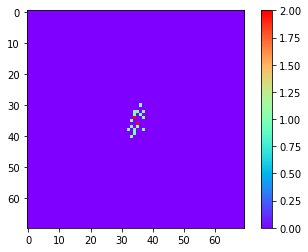

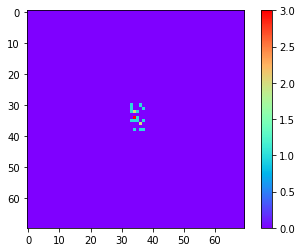

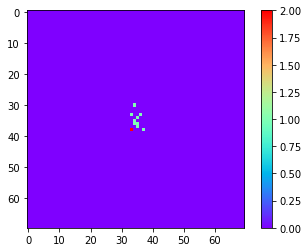

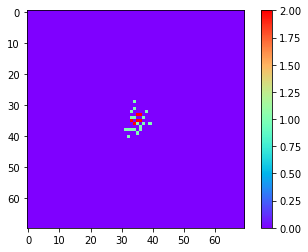

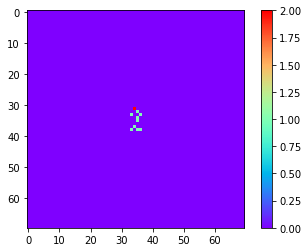

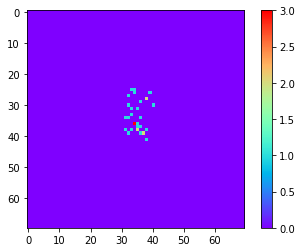

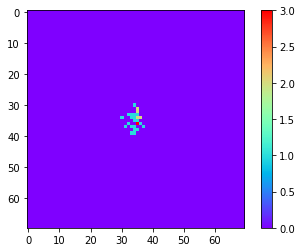

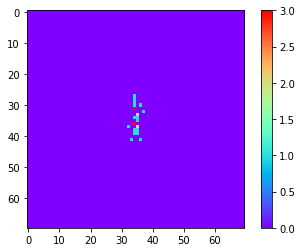

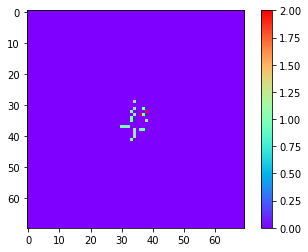

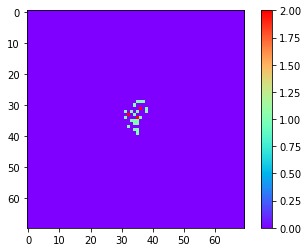

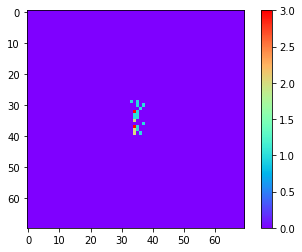

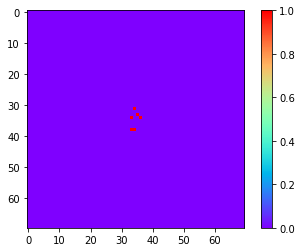

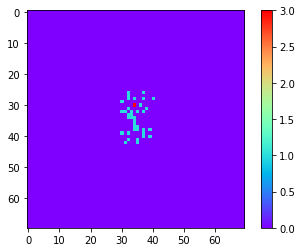

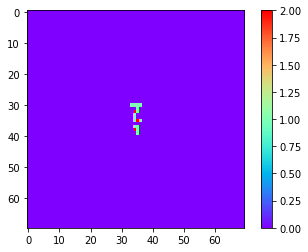

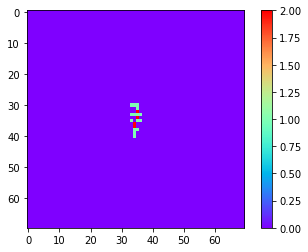

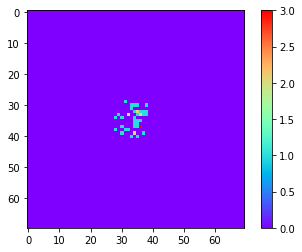

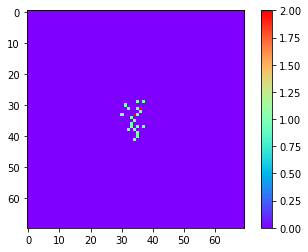

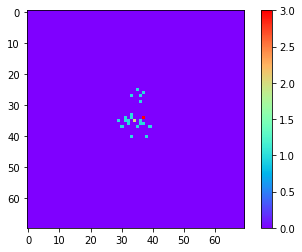

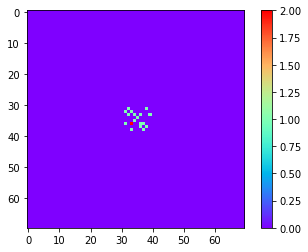

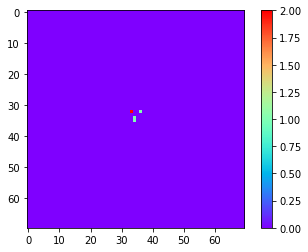

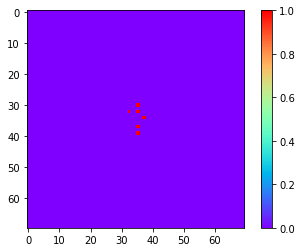

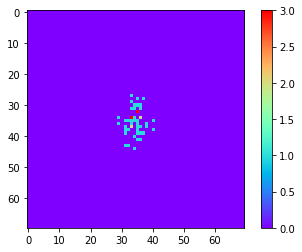

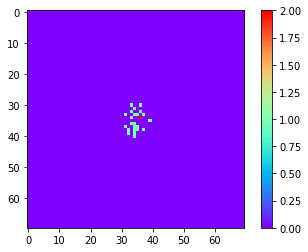

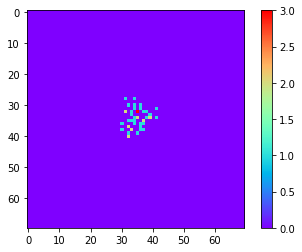

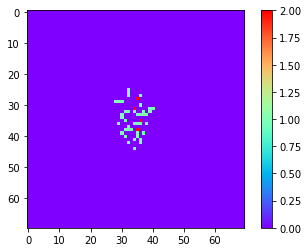

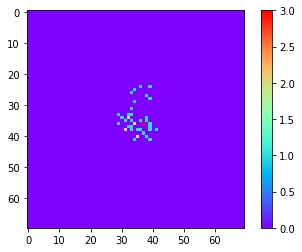

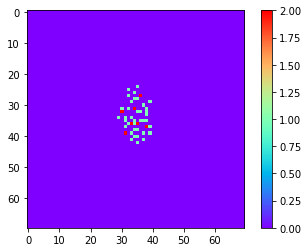

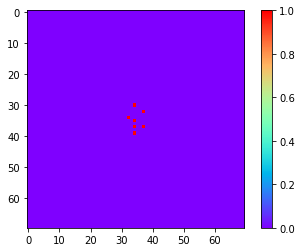

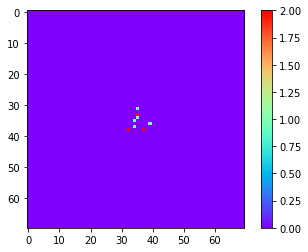

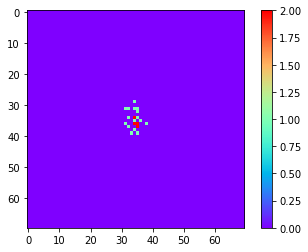

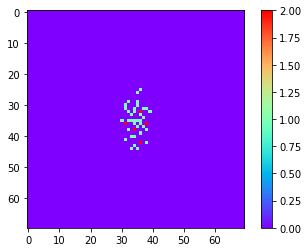

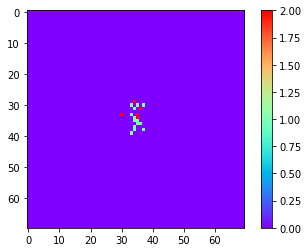

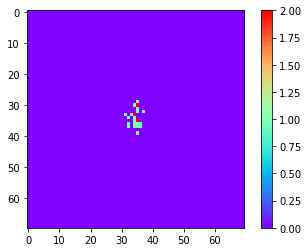

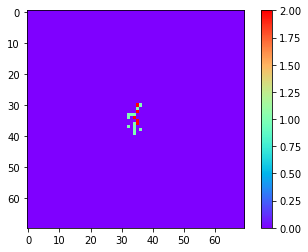

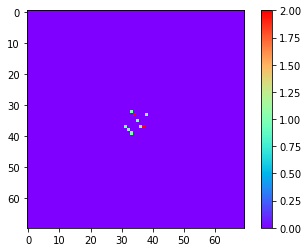

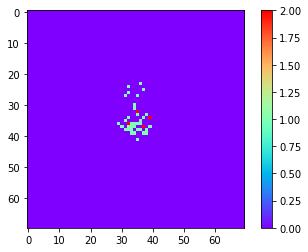

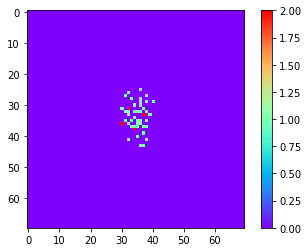

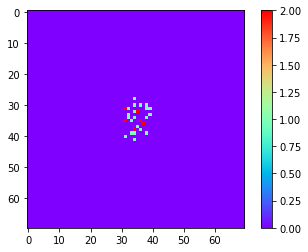

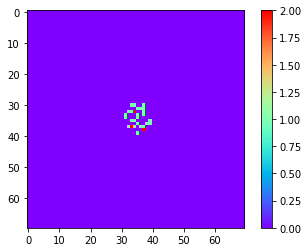

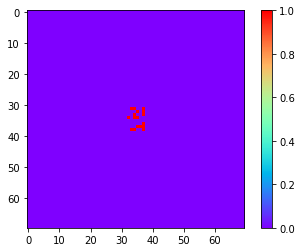

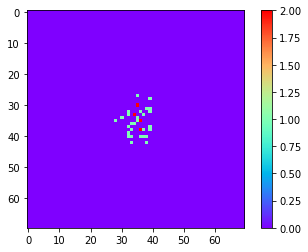

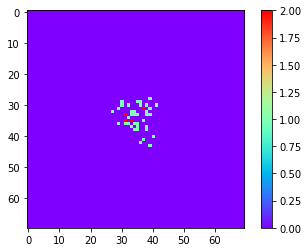

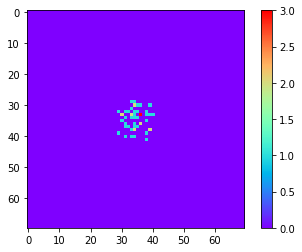

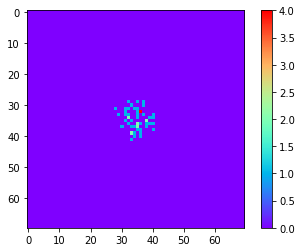

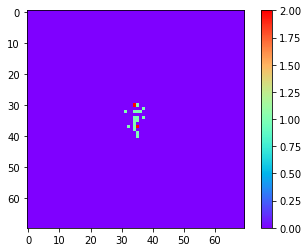

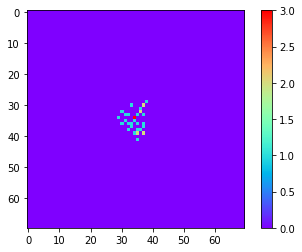

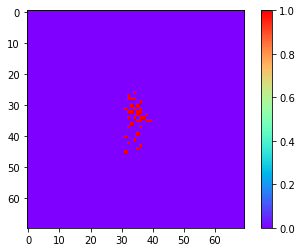

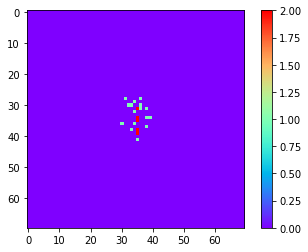

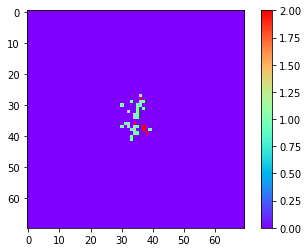

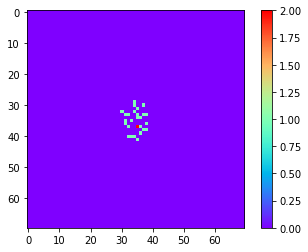

In [52]:
for i in range(50):
    vis.molecule_visualization2D(np.expand_dims(train_set[i][0].numpy().sum(axis=0).sum(axis=0),axis=0))

In [172]:
model.parameters()

<generator object Module.parameters at 0x7fa551c7eca8>

In [173]:
for f in model.parameters():
    print(f)
#     print('data is')
#     print(f.data)
#     print('grad is')
#     print(f.grad)

Parameter containing:
tensor([[[[[ 5.1371e-02,  3.8120e-02,  5.9627e-02],
           [-5.5404e-02, -1.4286e-02, -9.0682e-03],
           [-6.1930e-03,  4.4690e-02,  8.6186e-03]],

          [[ 6.2113e-02, -1.7580e-02, -7.3847e-02],
           [ 6.9574e-02,  3.9660e-02, -7.1597e-02],
           [-1.9775e-02, -5.6930e-02,  3.1993e-02]],

          [[ 6.2652e-02, -4.4029e-02, -6.2310e-02],
           [-5.3702e-03, -6.9392e-02,  2.4187e-02],
           [ 7.1772e-02, -2.4553e-02, -3.8751e-02]]],


         [[[-3.4688e-03,  2.0741e-02,  6.1599e-02],
           [ 2.7281e-02, -4.8626e-02, -5.5101e-02],
           [ 2.1256e-02,  2.6283e-02, -7.0569e-02]],

          [[-5.9242e-02,  6.8024e-02,  5.2904e-03],
           [ 3.1777e-02, -3.3375e-02, -3.7471e-02],
           [ 7.9789e-03,  4.7791e-02,  4.6652e-03]],

          [[-7.0653e-03, -5.3583e-02,  6.6849e-02],
           [-9.3354e-03,  9.9189e-03, -4.0019e-02],
           [-1.7245e-02,  6.1240e-02, -1.1306e-03]]],


         [[[ 3.1290e-03,  

In [174]:
model.sigma

tensor([1., 1., 1., 1., 1., 1.], requires_grad=True)

In [75]:
data_inp,target = train_set[0]

In [87]:
data_inp.shape

torch.Size([6, 70, 70, 70])

In [96]:
data_inp[5].nonzero()

tensor([[ 1,  2,  2],
        [ 5, 67, 66],
        [ 7,  0, 65],
        [ 9, 67,  0],
        [ 9, 69,  2],
        [10,  1, 69],
        [59,  0, 69],
        [61, 66,  0],
        [63,  4, 69],
        [66, 65,  0],
        [67,  4, 69]])

In [57]:
elements

{'Cl': 0, 'S': 1, 'N': 2, 'O': 3, 'C': 4, 'H': 5}

In [126]:
model(data_inp)

AttributeError: 'Tensor' object has no attribute 'apply'